# Final Year Project - Intelligent Health Monitoring System
#### by: Koo Chia Meng, A0165275Y

### DATA EXPLORATION:

### TREND VISUALISATION AND ANALYSIS - PERSON 1

#### Things we can visualise and compare:
1. Activity levels (determined by Step counts, peak HRs or amount of time in higher heart rates zones)
2. Health stats like (HR,RHR, derived HRV, calories and sleep in time series)

The insights gotten from this can be used to encourage users to be more active/ healthier, to achieve the goal of the Health monitoring. Proven in studies that it will improve.


Basing on the fact that the more we exercise, the healthier we get, we can compare between Active or non-Active and generically how the health stats changes over time. (Based on one person's data)

(With multiple person data) We can identify a base state of a person's health in comparison and whether the person is getting healthier or not over time.

(Future Application) Maybe an personalised app that can track these changes and give alerts / warnings, linking these stats to the onset of diseases (like "pre-diabetes", etc. something that we wont feel, but would slowly get worst if nothing had changed).

The main aim of the project is to involve minimal domain experts in real life and minimum intrusion/ disruption to the user.


We can also check/verified the following:
1. The acurracy of data
2. What we can get out of the data

In [1]:
#Import relevant Dependencies

import datetime
import time
import pandas as pd # Pandas Version 1.0.5
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import stats as sps
import sklearn.linear_model as lm
import seaborn as sns # use for visualising
import os

In [2]:
%run FYP_SUBJECTS_CLASS.ipynb # line needed to reuse the SUBJECT class created for OOP

### Loading Subjects from PICKLE

In [3]:
current_directory = os.getcwd()
folder = "PERSON1" # CHANGE HERE
file = "PERSON1_DATA_31JUL.pickle" # CHANGE HERE
f_path = os.path.join(current_directory,folder,file)
                      
with open(f_path,'rb') as f:
    PERSON1 = pickle.load(file=f)

In [4]:
PERSON1.profile

{'age': 28, 'gender': 'MALE', 'height': 170.0, 'weight': 75.0}

### Loading Previously Processed DFs from PICKLE

In [5]:
current_directory = os.getcwd()
folder = os.path.join("PERSON1","31JUL") # CHANGE HERE
folder_path = os.path.join(current_directory,folder)


In [6]:
# LOAD FROM PICKLE:

unpickle = {}
unpickle_list = [
                # Daily Resting Heart Rate DF:
                'df_resting_hr',

                # Daily Heart Rate Zones (HR Activities) DF:
                'df_hr_calories',

                # Intra-day Heart Rate DF:
                'df_intraday_hr',

                # Sleep Durations DF
                'df_sleep_durations',

                # Detailed intra Sleep Stages DF
                'df_intra_sleep_stage',

                # Daily Step activities DF:
                'df_activity_steps',
    
                # Derived HRV Stats DFs:
                'df_hrv_stats_full_day',
                'df_hrv_stats_AM',
                'df_hrv_stats_PM'
]

for i in unpickle_list:
    file = os.path.join(folder_path, str(i) + '.pickle')
    with open(file,'rb') as f:
        unpickle[i] = pickle.load(file=f)

PERSON1.df_resting_hr = unpickle['df_resting_hr']
PERSON1.df_hr_calories = unpickle['df_hr_calories']
PERSON1.df_intraday_hr = unpickle['df_intraday_hr']
PERSON1.df_sleep_durations = unpickle['df_sleep_durations']
PERSON1.df_intra_sleep_stage = unpickle['df_intra_sleep_stage']
PERSON1.df_activity_steps = unpickle['df_activity_steps']
PERSON1.df_hrv_stats_full_day = unpickle['df_hrv_stats_full_day']
PERSON1.df_hrv_stats_AM = unpickle['df_hrv_stats_AM']
PERSON1.df_hrv_stats_PM = unpickle['df_hrv_stats_PM']

### Plotting the DFs just by itself
Before comparing the different DFs with each other, it might be worthwhile to visualise individual DFs by itself. We can also see how the data itself looked like in time series before comparison.

#### Calories Recorded by Heart Rate Activities and Duration in Heart Rate Zones

In [7]:
PERSON1.df_hr_calories

Total_caloriesOut  minutes_Regular  minutes_Fatburn  \
dateTime                                                          
2020-02-21         3162.40842            709.0            273.0   
2020-02-22         2795.09988           1308.0             46.0   
2020-02-23         1672.70976            724.0             24.0   
2020-02-24         2398.43940            754.0             83.0   
2020-02-25         2817.55236            813.0            145.0   
...                       ...              ...              ...   
2020-07-27         3072.94932           1316.0             92.0   
2020-07-28         2544.26358           1387.0             46.0   
2020-07-29         2751.13044            579.0            227.0   
2020-07-30         2364.18160            900.0             97.0   
2020-07-31         2591.66820           1377.0             52.0   

            minutes_Cardio  minutes_Peak  Total_minutes  
dateTime                                                 
2020-02-21             7.0          24.0         1013.0  
2020-02-22             0.0           0.0         1354.0  
2020-02-23             0.0           0.0          748.0  
2020-02-24             0.0           0.0          837.0  
2020-02-25             6.0          13.0          977.0  
...                    ...           ...            ...  
2020-07-27             0.0           0.0         1408.0  
2020-07-28             0.0           0.0         1433.0  
2020-07-29             9.0           5.0          820.0  
2020-07-30             0.0           0.0          997.0  
2020-07-31             0.0           0.0         1429.0  

[127 rows x 6 columns]

### Splitting the data into months

In [8]:
PERSON1.df_hr_calories.index = pd.to_datetime(PERSON1.df_hr_calories.index) # Changing to DateTime index

In [9]:
PERSON1.df_hr_calories['month'] = PERSON1.df_hr_calories.index.month_name() # adding a column for month
PERSON1.df_hr_calories['m_num'] = PERSON1.df_hr_calories.index.month

In [10]:
# Splitting into data into dictionary of months:

month_list = list(PERSON1.df_hr_calories.month.unique())
col = [x for x in PERSON1.df_hr_calories.columns if 'total' not in x.lower() and 'm_num' not in x.lower()]

PERSON1.TotalCal = {}
PERSON1.HR_Zones = {} 

for mm in month_list:
    PERSON1.TotalCal[mm] = PERSON1.df_hr_calories['2020-' + mm].Total_caloriesOut
    PERSON1.HR_Zones[mm] = PERSON1.df_hr_calories.loc['2020-' + mm , col]

In [11]:
# Viewing the Number of records for each month:

PERSON1.df_hr_calories.groupby('month').count()

Total_caloriesOut  minutes_Regular  minutes_Fatburn  minutes_Cardio  \
month                                                                           
April                    17               17               17              17   
February                  9                9                9               9   
July                     27               27               27              27   
June                     25               25               25              25   
March                    28               28               28              28   
May                      21               21               21              21   

          minutes_Peak  Total_minutes  m_num  
month                                         
April               17             17     17  
February             9              9      9  
July                27             27     27  
June                25             25     25  
March               28             28     28  
May                 21             21     21

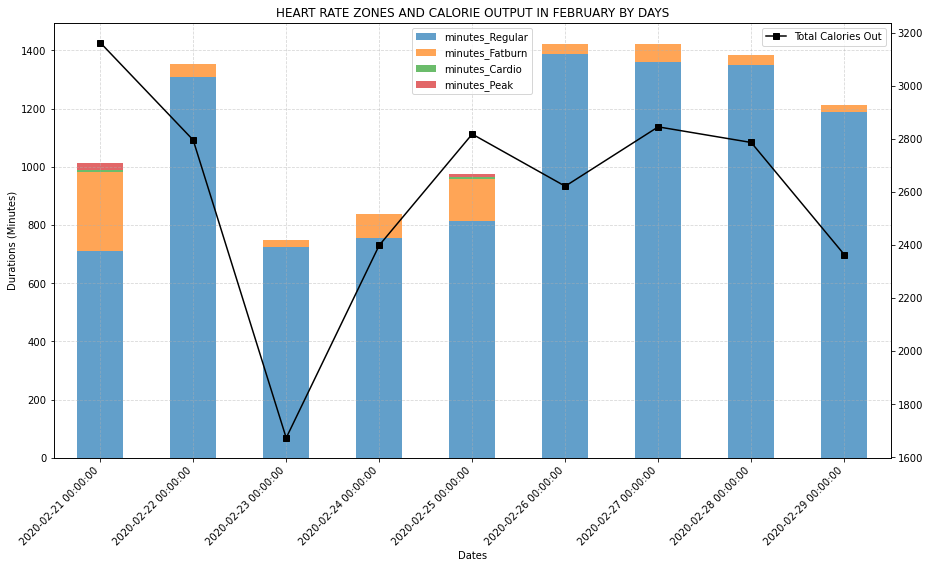

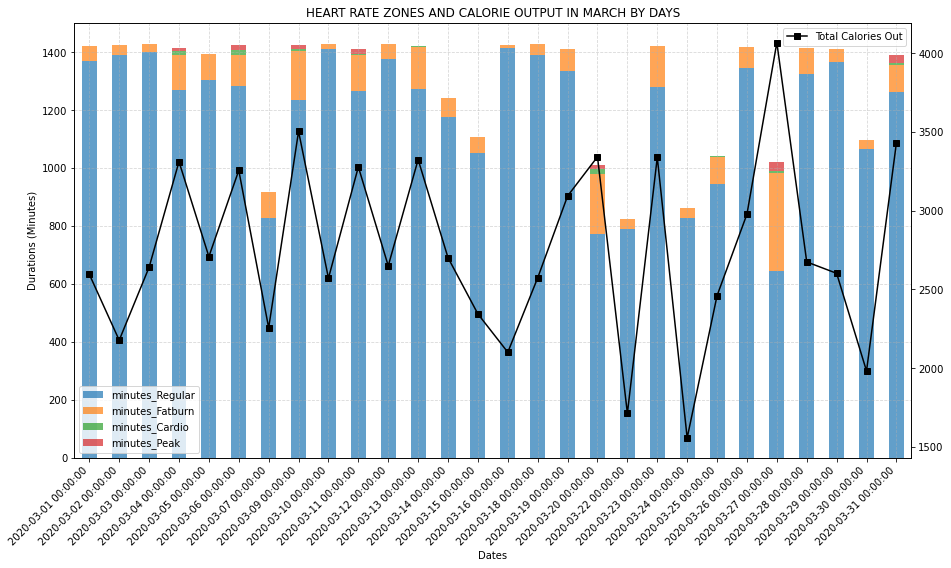

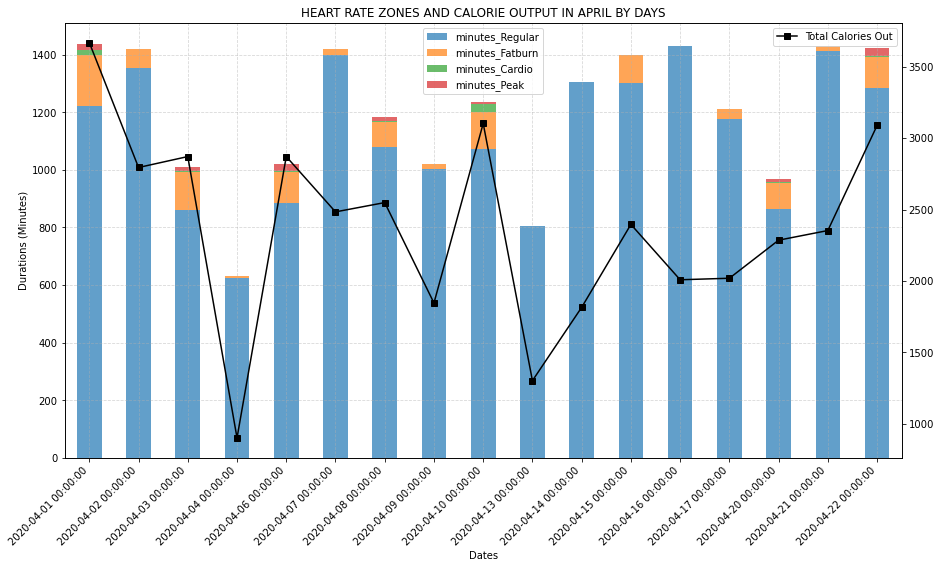

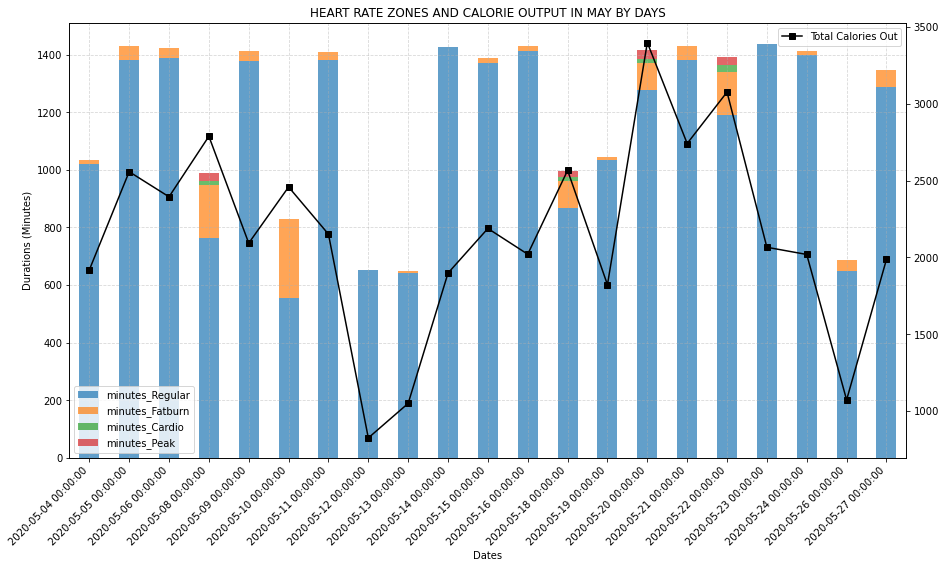

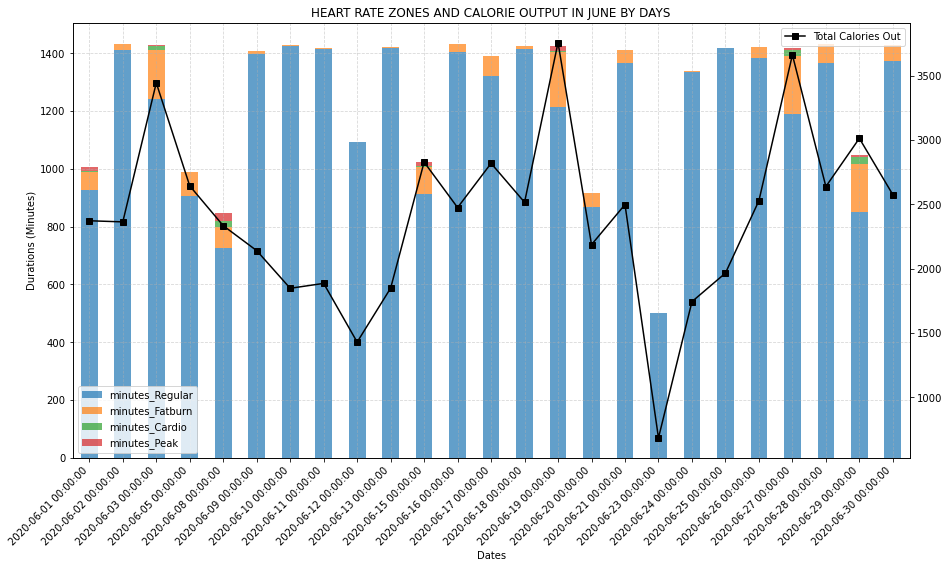

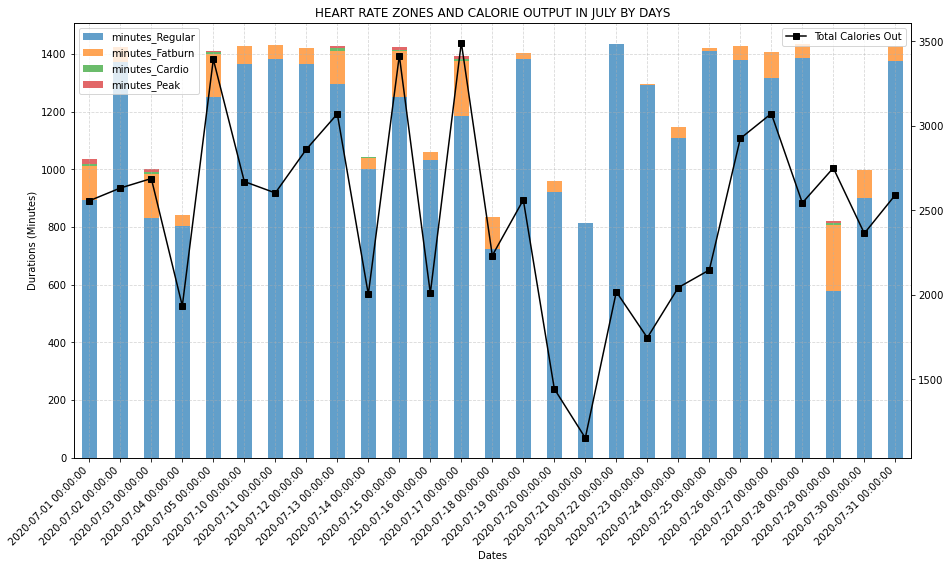

In [12]:
# Plotting using df.plot() splitting into months

for mm in month_list:
    
    PERSON1.HR_Zones[mm].plot(figsize=(15,8),kind='bar',stacked=True,alpha=0.7)

    plt.grid(True,alpha=0.5,ls='--')
    plt.title('HEART RATE ZONES AND CALORIE OUTPUT IN '+ mm.upper() + ' BY DAYS')
    plt.xticks(rotation=45,ha='right')
    plt.xlabel('Dates')
    plt.ylabel('Durations (Minutes)')

    ax2 = plt.twinx()
    ax2.plot(PERSON1.TotalCal[mm].values,'s-k',label='Total Calories Out')
    plt.legend()

    plt.show()

From the above plot:
1. the duration in the regular HR zone, makes up of the majority of the total calorie output.
2. the intensity of the day's activity is shown by the amount of time in different levels of HR zones.
    - "minutes_Peak" is the least, followed by "minutes_Cardio" and "minutes_Fatburn".
    - The days of exercise are shown in the peaks of the "minutes_Cardio" and "minutes_peak" plot
3. Calories will increase when the duration increases in HR zones above "Regular".
4. The records might not be from a full day (total durations less then 600 minutes or 10 Hours), which caused the dips.

#### Distribution of the HR Zone Durations and Calories

Overall Distribution:

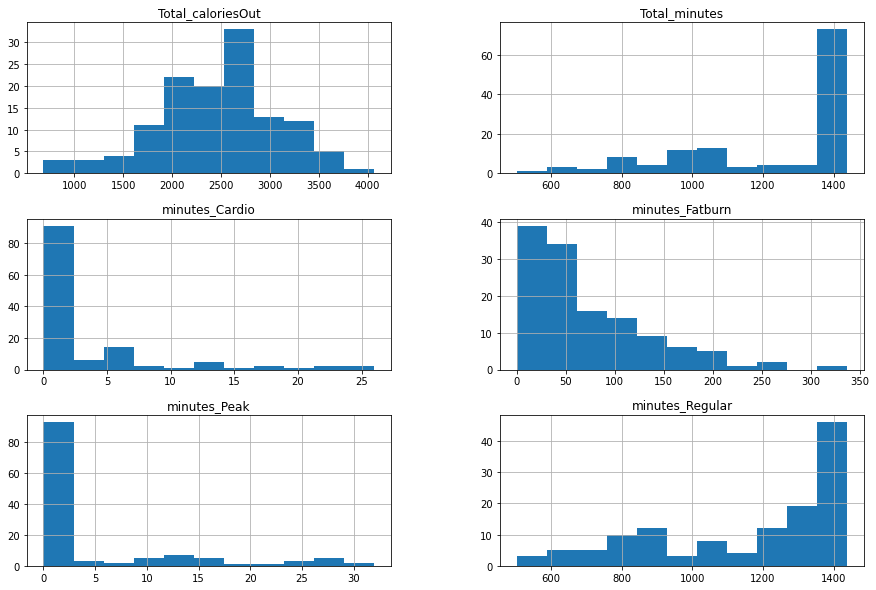

In [13]:
col = [x for x in PERSON1.df_hr_calories.columns if 'minutes' in x.lower() or 'total' in x.lower()]
PERSON1.df_hr_calories[col].hist(bins=11,figsize=(15,10))
plt.show()

The distribution of the Total Calories output is like a normal distribution, and probably averages at 2500.

Duration for the HR Zones looks more like exponential distributions. These durations are useful as they can also be used as a baseline, it can tell us info on how long we are in the state of raised HR (maybe due to exercise, stress, diseases etc).

Total Calories Distribution in individual months:

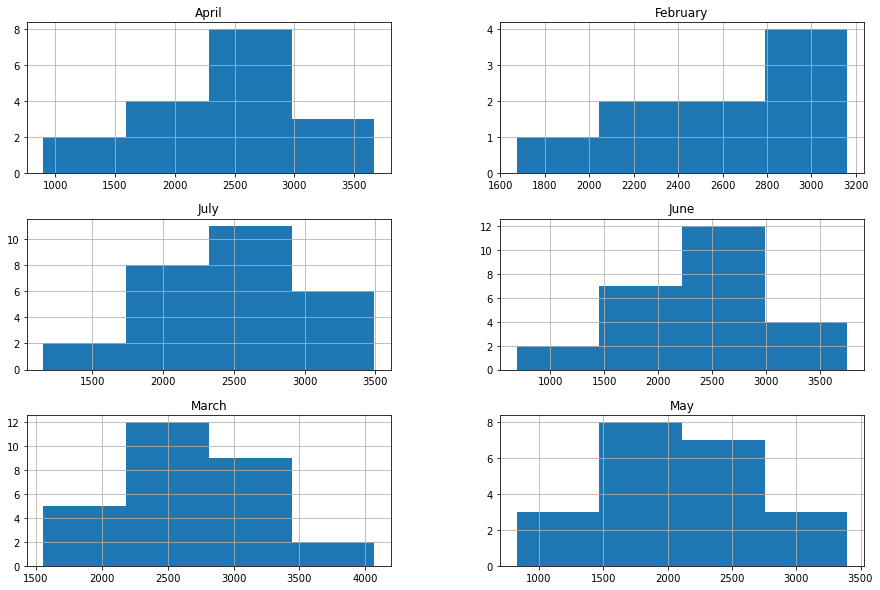

In [14]:
# Distribution of total calories in individual months

pd.concat(PERSON1.TotalCal,axis=1).hist(bins=4,figsize=(15,10))

plt.show()

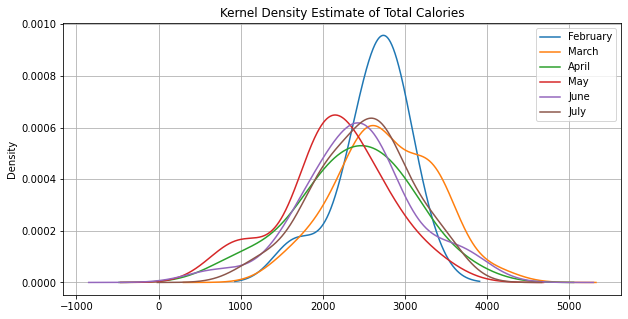

In [15]:
pd.concat(PERSON1.TotalCal,axis=1).plot(kind='kde',figsize=(10,5))
plt.grid()
plt.title('Kernel Density Estimate of Total Calories')
plt.show()

In general, the calories output for PERSON1 is in the region between 2000 and 3000, around 2500 per day as shown in the plots above.

### Comparison Between Months

#### Checking Active Days

In [16]:
# Counting the numbner of Active days (days of exercise):

def count_nonZero(z):
    count = 0
    for x in z:
        if x !=0:
            count = count + 1
    return count

pivot_hr_cal = PERSON1.df_hr_calories.pivot_table(values=['minutes_Peak','minutes_Cardio','minutes_Fatburn'],
                                                  index='m_num', aggfunc=count_nonZero).sort_index()
pivot_hr_cal

minutes_Cardio  minutes_Fatburn  minutes_Peak
m_num                                               
2                 2.0              9.0           2.0
3                 9.0             28.0           7.0
4                 7.0             15.0           7.0
5                 4.0             18.0           4.0
6                 9.0             23.0           7.0
7                 8.0             26.0           7.0

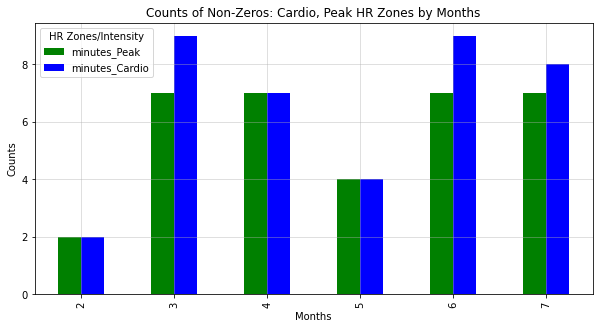

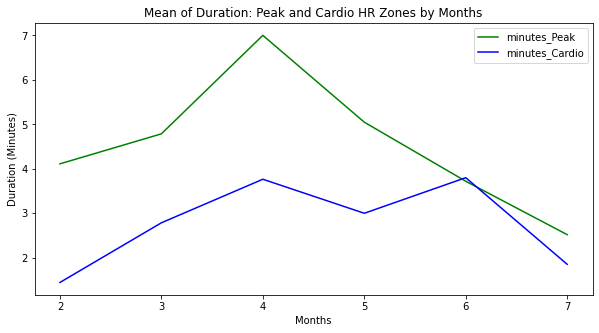

In [17]:
#Plotting the count of non-zeros for Minute_Cardio, Minute_Fatburn and Minute_Peak

# the intensity level (Lower to Higher): 1.Fat burn, 2.Cardio, 3.Peak 

pivot_hr_cal[['minutes_Peak','minutes_Cardio']].plot(kind='bar',figsize=(10,5),color=['green','blue'])
plt.title('Counts of Non-Zeros: Cardio, Peak HR Zones by Months')
plt.ylabel('Counts')
plt.xlabel('Months')

plt.legend(title='HR Zones/Intensity')

plt.grid(':',alpha=0.5)
PERSON1.df_hr_calories.groupby('m_num')[['minutes_Peak','minutes_Cardio']].mean().plot(figsize=(10,5),color=['green','blue'])
plt.title('Mean of Duration: Peak and Cardio HR Zones by Months')
plt.ylabel('Duration (Minutes)')
plt.xlabel('Months')
plt.show()


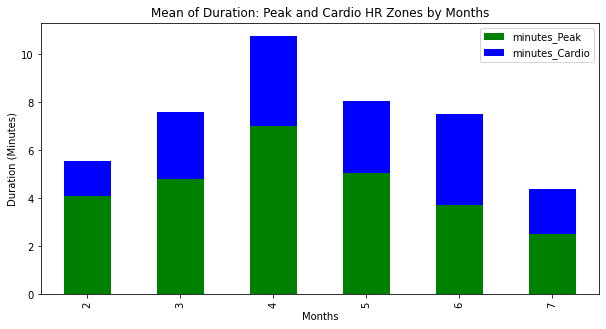

In [18]:
PERSON1.df_hr_calories.groupby('m_num')[['minutes_Peak','minutes_Cardio']].mean().plot(kind='bar',stacked=True,figsize=(10,5),color=['green','blue'])
plt.title('Mean of Duration: Peak and Cardio HR Zones by Months')
plt.ylabel('Duration (Minutes)')
plt.xlabel('Months')
plt.show()

In [19]:
Total_active_duration = PERSON1.df_hr_calories[['minutes_Peak','minutes_Cardio']].sum(axis=1)
Total_active_duration.index = pd.to_datetime(Total_active_duration.index)
Total_active_duration = pd.DataFrame({'m_num':Total_active_duration.index.month,
                                               'Very_Active_Duration':Total_active_duration})
Total_active_duration.groupby('m_num').mean()*7

Very_Active_Duration
m_num                      
2                 38.888889
3                 53.000000
4                 75.352941
5                 56.333333
6                 52.640000
7                 30.592593

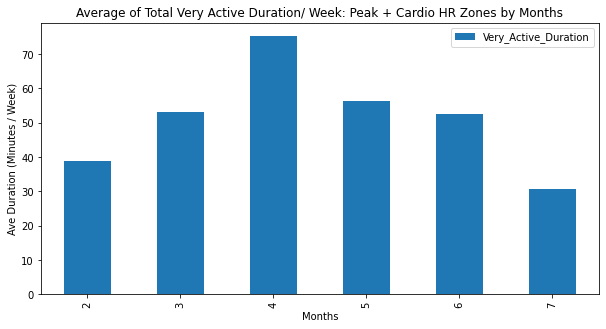

In [20]:
Ave_per_week = Total_active_duration.groupby('m_num').mean()*7 # Average Per Week

Ave_per_week.plot(kind='bar',figsize=(10,5))
plt.title('Average of Total Very Active Duration/ Week: Peak + Cardio HR Zones by Months')
plt.ylabel('Ave Duration (Minutes / Week)')
plt.xlabel('Months')
plt.show()

In [21]:
PERSON1.df_hr_calories.groupby('m_num')[['minutes_Peak','minutes_Cardio']].max()


minutes_Peak  minutes_Cardio
m_num                              
2              24.0             7.0
3              32.0            17.0
4              27.0            26.0
5              30.0            25.0
6              29.0            23.0
7              17.0            10.0

Judging from the count of non zero minutes_Peak, there are more recorded days exercised are similar in MAR, APR, JUN and JUL at <b>7 days</b>.

The mean plot of Peak and Cardio minutes shows that on average, the exercise in APR had the more intensity (longer duration in higher HR zones).

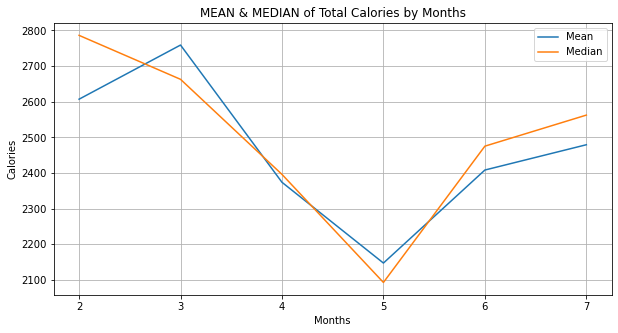

In [22]:
plt.figure(figsize=(10,5))

plt.plot(PERSON1.df_hr_calories.groupby('m_num')['Total_caloriesOut'].mean(),label='Mean')

plt.plot(PERSON1.df_hr_calories.groupby('m_num')['Total_caloriesOut'].median(),label='Median')
plt.title('MEAN & MEDIAN of Total Calories by Months')
plt.xlabel('Months')
plt.ylabel('Calories')
plt.grid()
plt.legend()
plt.show()

The Mean and Median shows that since FEB, recorded activity gets lesser towards MAY.  FEB had lesser data points might had resulted in a higher mean and median. We will later cross check with steps.

### EXPLORING Step Activities


In [23]:
# Changing the index into datetimeindex.
PERSON1.df_activity_steps.index = pd.to_datetime(PERSON1.df_activity_steps.index)

PERSON1.df_activity_steps['month'] = PERSON1.df_activity_steps.index.month
PERSON1.df_activity_steps['m_num'] = PERSON1.df_activity_steps.index.month_name()

PERSON1.df_activity_steps

step_count  month     m_num
dateTime                               
2020-02-21       12981      2  February
2020-02-22       12802      2  February
2020-02-23        9030      2  February
2020-02-24       15361      2  February
2020-02-25       12570      2  February
...                ...    ...       ...
2020-07-27       14356      7      July
2020-07-28        8149      7      July
2020-07-29       13651      7      July
2020-07-30       10888      7      July
2020-07-31        9727      7      July

[118 rows x 3 columns]

In [24]:
# Viewing the number of records:

PERSON1.df_activity_steps[['step_count','month']].groupby('month').count()

step_count
month            
2               9
3              28
4              16
5              17
6              19
7              29

#### Distribution for Steps

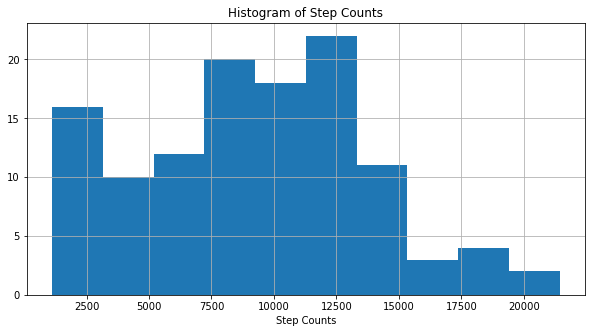

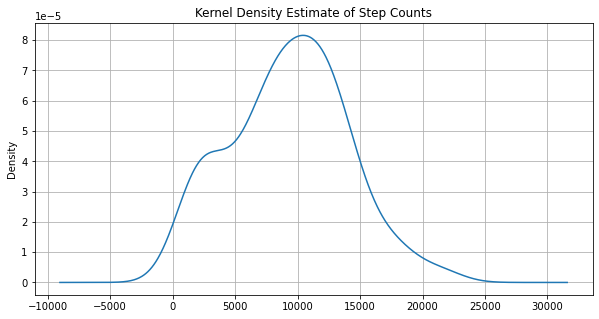

In [25]:
PERSON1.df_activity_steps.step_count.hist(figsize=(10,5))
plt.xlabel('Step Counts')
plt.title('Histogram of Step Counts')
plt.show()

PERSON1.df_activity_steps.step_count.plot(kind='kde',figsize=(10,5))
plt.grid()
plt.title('Kernel Density Estimate of Step Counts')
plt.show()

The Step distribution follows sort of Normal distribution, if excluing the close to zeros values, in the first stage, only records below 1000 were excluded.

Next, split into weeks or months to compare:

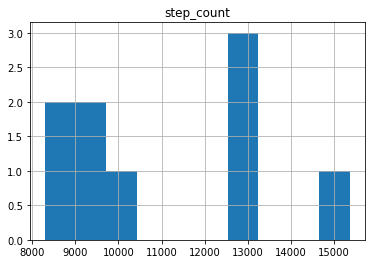

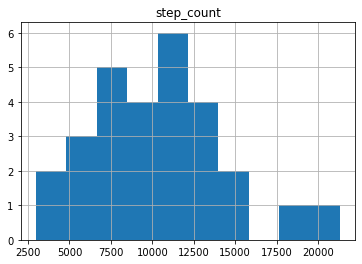

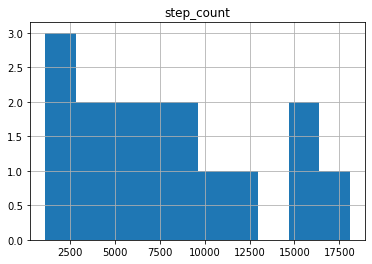

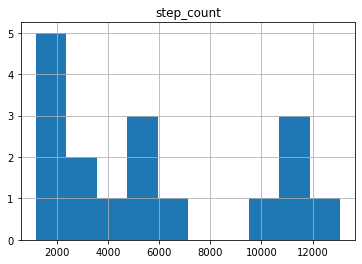

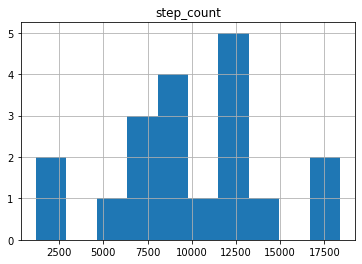

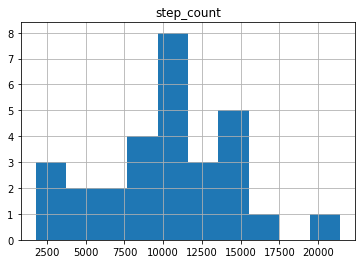

In [26]:
PERSON1.df_activity_steps[['step_count','month']].groupby('month').hist()
plt.show()

As seen from the above histogram plots, the distribution of steps in each month does not really follow a normal distribution.

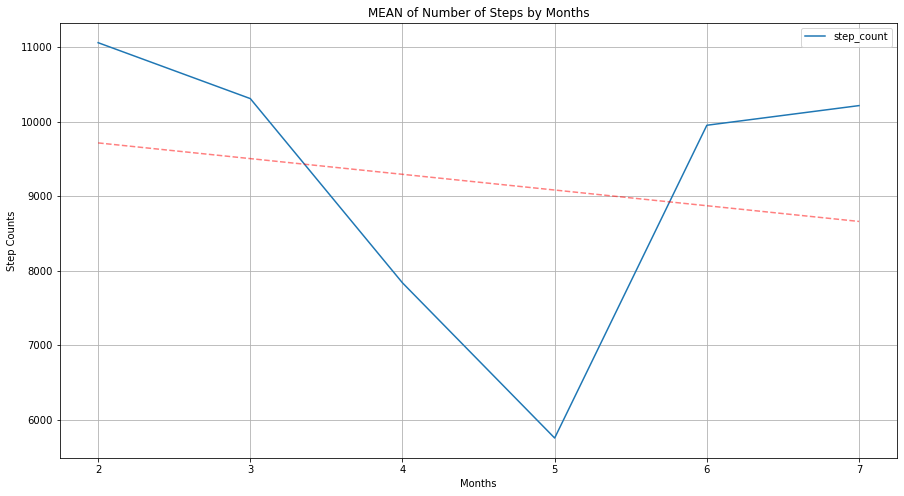

In [27]:
# Trend of steps for the months:
grouped_steps = PERSON1.df_activity_steps[['step_count','month']].groupby('month').mean()
grouped_steps.plot(figsize=(15,8),label='Mean')


# Linear Regression Fit for trendline:
lm_step = lm.LinearRegression()
lm_step.fit(grouped_steps.index.to_numpy().reshape(-1, 1),
                  grouped_steps.to_numpy().reshape(-1, 1))
pred_steps = lm_step.predict(grouped_steps.index.to_numpy().reshape(-1, 1))

plt.plot(grouped_steps.index,pred_steps,'--r',alpha=0.5)

plt.title('MEAN of Number of Steps by Months')
plt.xlabel('Months')
plt.ylabel('Step Counts')
plt.grid()
plt.legend()
plt.show()

As verified from the above mean plot, MAY does had the least amount of steps in average.

### Exploring Sleep Data

#### Sleep Durations and Sleep Stages

In [28]:
# Renamed the columns for lesser confusion.
PERSON1.df_sleep_durations = PERSON1.df_sleep_durations.rename(columns={'duration':'sleep_duration','efficiency':'sleep_efficiency'})
PERSON1.df_sleep_durations

sleep_duration  minutesAsleep  sleep_efficiency  \
dateOfSleep                                                    
2020-07-31            576.0            499                86   
2020-07-28            450.0            386                94   
2020-07-27            221.0            187                88   
2020-07-26            534.0            460                91   
2020-07-25            573.0            464                87   
...                     ...            ...               ...   
2020-02-29            188.0            163                95   
2020-02-28            303.0            260                91   
2020-02-27            419.0            351                89   
2020-02-26            388.0            339                90   
2020-02-22            615.0            530                88   

                      startTime             endTime  DeepSleep_Count  \
dateOfSleep                                                            
2020-07-31  2020-07-31 00:22:00 2020-07-31 09:58:30              5.0   
2020-07-28  2020-07-27 23:15:30 2020-07-28 06:45:30              3.0   
2020-07-27  2020-07-27 06:01:00 2020-07-27 09:42:00              3.0   
2020-07-26  2020-07-26 00:02:00 2020-07-26 08:56:30              5.0   
2020-07-25  2020-07-25 02:41:30 2020-07-25 12:14:30              6.0   
...                         ...                 ...              ...   
2020-02-29  2020-02-29 07:10:30 2020-02-29 10:18:30              1.0   
2020-02-28  2020-02-28 02:05:30 2020-02-28 07:08:30              1.0   
2020-02-27  2020-02-27 00:03:00 2020-02-27 07:02:30              4.0   
2020-02-26  2020-02-26 00:34:00 2020-02-26 07:02:00              3.0   
2020-02-22  2020-02-21 23:25:00 2020-02-22 09:40:30              4.0   

             DeepSleep_Minutes  LightSleep_Count  LightSleep_Minutes  \
dateOfSleep                                                            
2020-07-31                91.0              44.0               295.0   
2020-07-28                66.0              35.0               240.0   
2020-07-27                30.0              24.0               122.0   
2020-07-26                79.0              52.0               298.0   
2020-07-25                96.0              50.0               280.0   
...                        ...               ...                 ...   
2020-02-29                16.0              17.0               124.0   
2020-02-28                 8.0              24.0               220.0   
2020-02-27                51.0              32.0               193.0   
2020-02-26                58.0              33.0               218.0   
2020-02-22                69.0              43.0               353.0   

             RemSleep_Count  RemSleep_Minutes  Wake_Count  Wake_Minutes  
dateOfSleep                                                              
2020-07-31             25.0             113.0        59.0          77.0  
2020-07-28             12.0              80.0        41.0          64.0  
2020-07-27              6.0              35.0        27.0          34.0  
2020-07-26             13.0              83.0        55.0          74.0  
2020-07-25             23.0              88.0        67.0         109.0  
...                     ...               ...         ...           ...  
2020-02-29              5.0              23.0        19.0          25.0  
2020-02-28              5.0              32.0        25.0          43.0  
2020-02-27             20.0             107.0        46.0          68.0  
2020-02-26             10.0              63.0        34.0          49.0  
2020-02-22             16.0             108.0        52.0          85.0  

[96 rows x 13 columns]

#### Sleep Efficiency

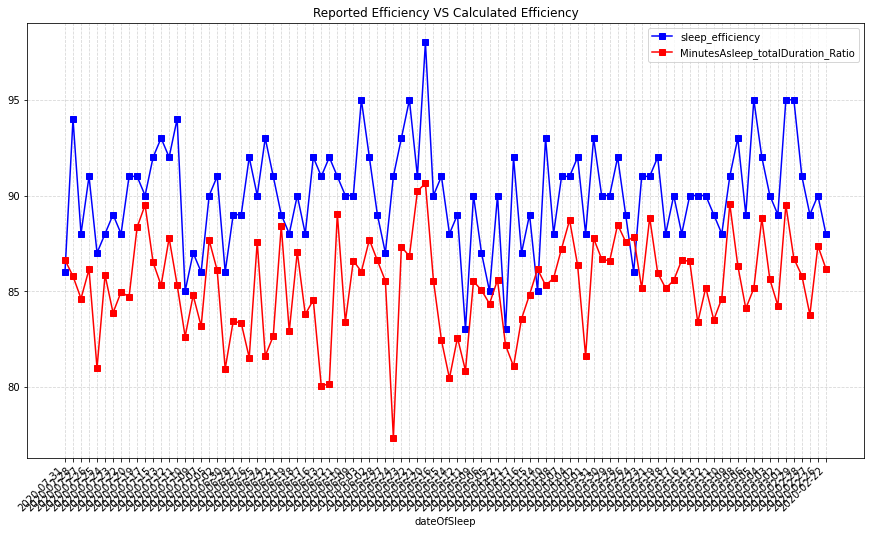

In [29]:
# Exploring the sleep efficiency

asleepVStotal_ratio = PERSON1.df_sleep_durations.minutesAsleep/PERSON1.df_sleep_durations.sleep_duration

PERSON1.df_sleep_durations['sleep_efficiency'].plot(figsize=(15,8),color='b',marker='s')
plt.plot(asleepVStotal_ratio*100,color='r',marker='s',label='MinutesAsleep_totalDuration_Ratio')

plt.xticks(PERSON1.df_sleep_durations.index,PERSON1.df_sleep_durations.index,
           rotation=45,ha='right')
plt.grid(True,alpha=0.5,ls='--')
plt.legend()
plt.title('Reported Efficiency VS Calculated Efficiency')
plt.show()

As observed above, Sleep efficiency was not equal to the ratio of minute asleep to the total sleep duration. The Sleep Efficiency definition given by FitBit was: 
- time asleep / (total time in bed - time to fall asleep)

However the time to fall asleep were not reflected in the fetched data to verify the calculations. The time to falling asleep can also be calculated backwards if required.

The sleep efficiency calculated by fitbit were generally higher than the simple ratio of minutes asleep over total duration of sleep, with the inclusion of time to fall asleep.


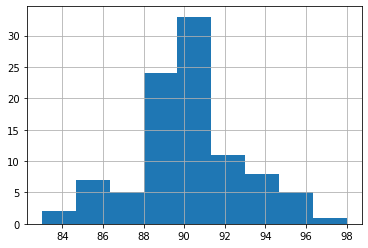

In [30]:
# DISTRIBUTION OF SLEEP EFFICIENCY

PERSON1.df_sleep_durations['sleep_efficiency'].hist(bins=9)
plt.show()

#### Verifying of Total Sleep Durations

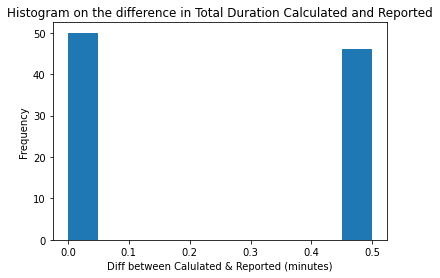

In [31]:
# Calculating the total duration in bed using start time and end time.
# and Comparing with the reported Total Durations

x_duration = (PERSON1.df_sleep_durations.endTime - PERSON1.df_sleep_durations.startTime)
x_duration_diff = x_duration.dt.total_seconds()/float(60) - PERSON1.df_sleep_durations.sleep_duration
x_duration_diff.plot(kind='hist')
plt.title('Histogram on the difference in Total Duration Calculated and Reported')
plt.xlabel('Diff between Calulated & Reported (minutes)')
plt.show()

As shown, the total duration calculations were a bit off for certain days, but the delta were not a lot. At most 30 seconds, for half of the records. 

#### Percentage Duration for each phase of sleep

In order to compare this statistic more meaningfully, the duration of each sleep stage should be calculated in percentage of the total sleep duration. (X_Minutes/sleep_duration)* 100, where X is the respective sleep stages.

In [32]:
# Finding Percentage of each Sleep Stage out of total sleep duration

Sleep_Stage_Durations = PERSON1.df_sleep_durations[[x for x in PERSON1.df_sleep_durations.columns if 'minutes' in x.lower()]]

# Percentage of sleep stage duration out of sleep duration
Percent_Sleep_Durations = Sleep_Stage_Durations.apply(lambda x: x/PERSON1.df_sleep_durations.sleep_duration * 100)
Percent_Sleep_Durations

minutesAsleep  DeepSleep_Minutes  LightSleep_Minutes  \
dateOfSleep                                                         
2020-07-31       86.631944          15.798611           51.215278   
2020-07-28       85.777778          14.666667           53.333333   
2020-07-27       84.615385          13.574661           55.203620   
2020-07-26       86.142322          14.794007           55.805243   
2020-07-25       80.977312          16.753927           48.865620   
...                    ...                ...                 ...   
2020-02-29       86.702128           8.510638           65.957447   
2020-02-28       85.808581           2.640264           72.607261   
2020-02-27       83.770883          12.171838           46.062053   
2020-02-26       87.371134          14.948454           56.185567   
2020-02-22       86.178862          11.219512           57.398374   

             RemSleep_Minutes  Wake_Minutes  
dateOfSleep                                  
2020-07-31          19.618056     13.368056  
2020-07-28          17.777778     14.222222  
2020-07-27          15.837104     15.384615  
2020-07-26          15.543071     13.857678  
2020-07-25          15.357766     19.022688  
...                       ...           ...  
2020-02-29          12.234043     13.297872  
2020-02-28          10.561056     14.191419  
2020-02-27          25.536993     16.229117  
2020-02-26          16.237113     12.628866  
2020-02-22          17.560976     13.821138  

[96 rows x 5 columns]

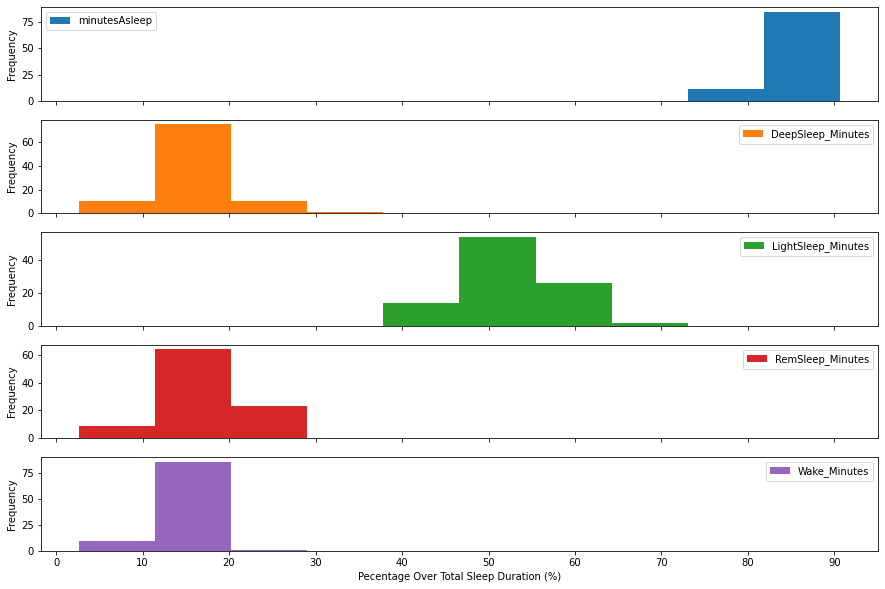

In [33]:
# Plotting out HISTOGRAM of percentage duration of each stage

Percent_Sleep_Durations.plot(kind='hist',bins=10,subplots=True,figsize=(15,10))
plt.xticks(np.linspace(0,100,num=10,endpoint=False))
plt.xlabel('Pecentage Over Total Sleep Duration (%)')
plt.show()

Deep sleep, REM sleep and wake timing occupies about <b>15%</b> of the total sleep duration. Light sleep occurs roughly <b>50%</b> of total duration.

In [72]:
print("Percentage Duration of Sleep Stages:")

Percent_Sleep_Durations.mean()

Percentage Duration of Sleep Stages:


minutesAsleep         85.306307
DeepSleep_Minutes     15.211982
LightSleep_Minutes    52.671242
RemSleep_Minutes      17.423083
Wake_Minutes          14.693693
dtype: float64

In [34]:

Sleep_Stage_Counts = PERSON1.df_sleep_durations[[x for x in PERSON1.df_sleep_durations.columns if 'count' in x.lower()]]
Sleep_Stage_Counts

DeepSleep_Count  LightSleep_Count  RemSleep_Count  Wake_Count
dateOfSleep                                                               
2020-07-31               5.0              44.0            25.0        59.0
2020-07-28               3.0              35.0            12.0        41.0
2020-07-27               3.0              24.0             6.0        27.0
2020-07-26               5.0              52.0            13.0        55.0
2020-07-25               6.0              50.0            23.0        67.0
...                      ...               ...             ...         ...
2020-02-29               1.0              17.0             5.0        19.0
2020-02-28               1.0              24.0             5.0        25.0
2020-02-27               4.0              32.0            20.0        46.0
2020-02-26               3.0              33.0            10.0        34.0
2020-02-22               4.0              43.0            16.0        52.0

[96 rows x 4 columns]

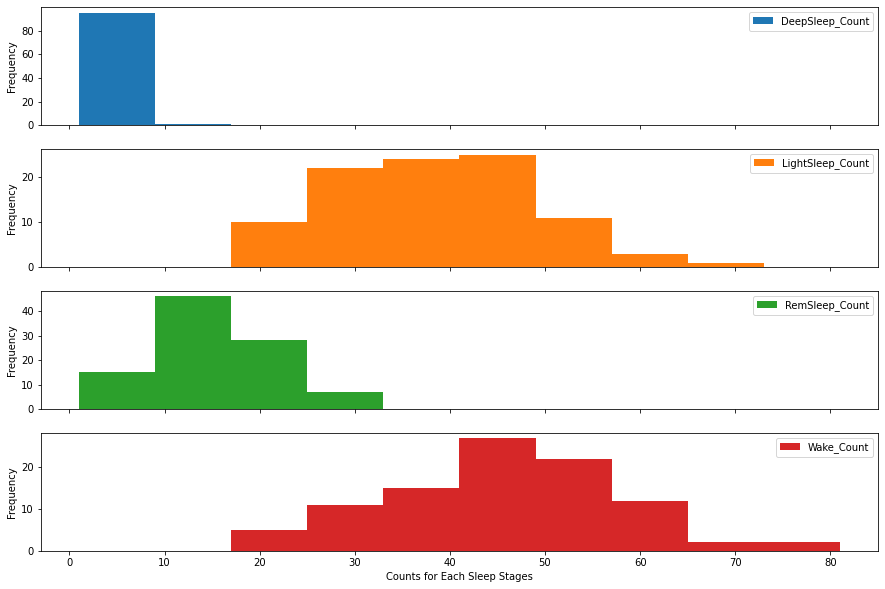

In [35]:
# Plotting out HISTOGRAM for sleep stage counts

Sleep_Stage_Counts.plot(kind='hist',bins=10,subplots=True,figsize=(15,10))
plt.xlabel('Counts for Each Sleep Stages')
plt.show()

From the histograms above, it seems like the sleep stage durations and counts follow something like a normal distribution.

#### Finding the averaged durations for each Sleep Stage over the respective counts

To better use of both statistic of Sleep stages, the sleep stage count and durations can be combined into a single stat, avergage duration per count.

In [36]:
# Finding the averaged durations for each Sleep Stage over the respective counts

# Rename Column Name to be the same as 'Percent_Sleep_Durations' to for division
Sleep_Stage_Counts.columns = Percent_Sleep_Durations.drop(columns='minutesAsleep').columns

# Finding ave duration for each stage in seconds
Ave_Stage_Duration = ((Percent_Sleep_Durations.drop(columns='minutesAsleep')/Sleep_Stage_Counts)*float(60))

# Rename Column Name
Ave_Stage_Duration.columns = Ave_Stage_Duration.columns.str.replace('Minutes','SecPerCount')

Ave_Stage_Duration



DeepSleep_SecPerCount  LightSleep_SecPerCount  \
dateOfSleep                                                  
2020-07-31              189.583333               69.839015   
2020-07-28              293.333333               91.428571   
2020-07-27              271.493213              138.009050   
2020-07-26              177.528090               64.390666   
2020-07-25              167.539267               58.638743   
...                            ...                     ...   
2020-02-29              510.638298              232.790989   
2020-02-28              158.415842              181.518152   
2020-02-27              182.577566               86.366348   
2020-02-26              298.969072              102.155576   
2020-02-22              168.292683               80.090754   

             RemSleep_SecPerCount  Wake_SecPerCount  
dateOfSleep                                          
2020-07-31              47.083333         13.594633  
2020-07-28              88.888889         20.813008  
2020-07-27             158.371041         34.188034  
2020-07-26              71.737252         15.117467  
2020-07-25              40.063738         17.035243  
...                           ...               ...  
2020-02-29             146.808511         41.993281  
2020-02-28             126.732673         34.059406  
2020-02-27              76.610979         21.168413  
2020-02-26              97.422680         22.286234  
2020-02-22              65.853659         15.947467  

[96 rows x 4 columns]

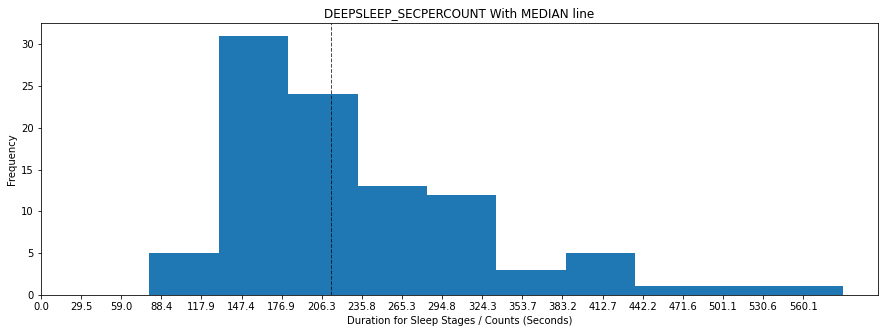

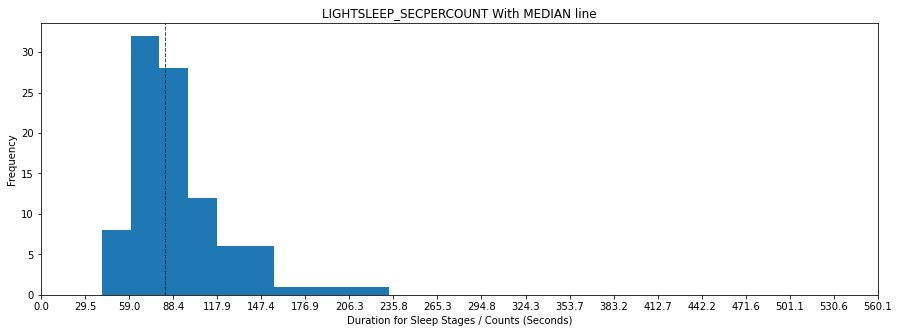

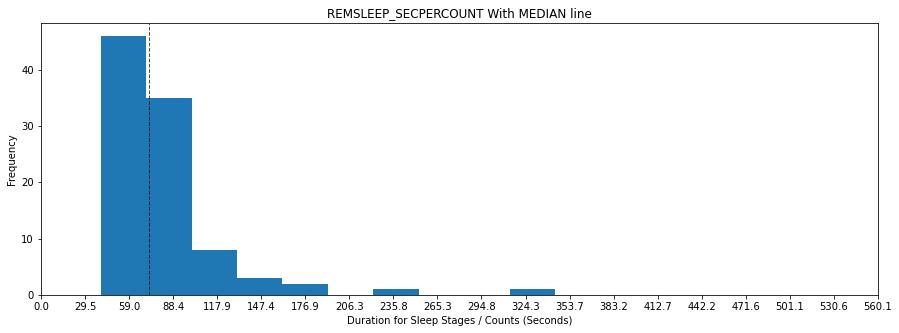

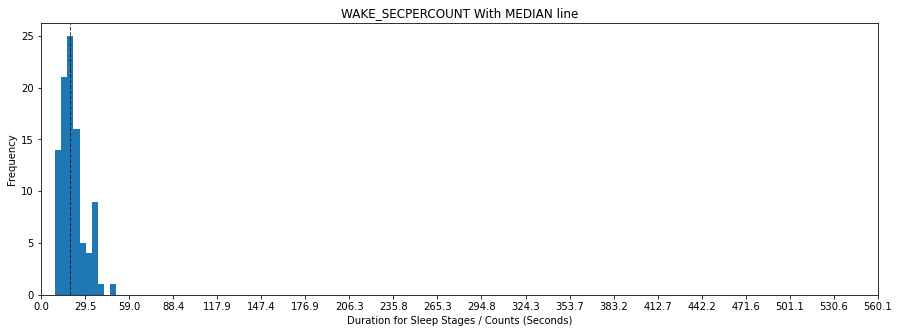

In [37]:
# Plotting out HISTOGRAM

MAX = max(Ave_Stage_Duration.max())

for col in Ave_Stage_Duration:
    Ave_Stage_Duration[col].plot(kind='hist',bins=10,figsize=(15,5))
    plt.axvline(Ave_Stage_Duration[col].median(), color='k', linestyle='dashed', linewidth=1,alpha=0.7)
    plt.xticks(np.linspace(0,MAX,num=20,endpoint=False))
    plt.xlabel('Duration for Sleep Stages / Counts (Seconds)')
    plt.title(col.upper()+' With MEDIAN line')
    plt.show()

Deep Sleep duration per count appears to be higher because the counts are lower, as compare to the other stages. This value could be use to tell when the counts for the stage had increased or the duration for the stage had increased.

Wake had the least value as the counts are more than others.

#### Intraday Heart Rate During Sleep Stages 

In [38]:
PERSON1.df_intra_sleep_stage

dateOfSleep  level  minutes      date      time
dateTime                                                           
2020-07-31 00:22:00  2020-07-31   wake      5.0  20-07-31  00:22:00
2020-07-31 00:27:00  2020-07-31  light     10.0  20-07-31  00:27:00
2020-07-31 00:37:00  2020-07-31   deep      7.0  20-07-31  00:37:00
2020-07-31 00:44:00  2020-07-31  light     22.0  20-07-31  00:44:00
2020-07-31 01:06:00  2020-07-31   deep     12.0  20-07-31  01:06:00
...                         ...    ...      ...       ...       ...
2020-02-22 08:33:30  2020-02-22   wake      5.5  20-02-22  08:33:30
2020-02-22 08:39:00  2020-02-22  light     37.0  20-02-22  08:39:00
2020-02-22 09:16:00  2020-02-22   wake      6.0  20-02-22  09:16:00
2020-02-22 09:22:00  2020-02-22    rem     16.0  20-02-22  09:22:00
2020-02-22 09:38:00  2020-02-22   deep      2.5  20-02-22  09:38:00

[2448 rows x 5 columns]

In [39]:
PERSON1.df_intraday_hr

time  value        date            timestamp  \
d_time                                                                  
2020-02-23 10:12:00  10:12:00     70  2020-02-23 -2208952080000000000   
2020-02-23 10:12:15  10:12:15     70  2020-02-23 -2208952065000000000   
2020-02-23 10:12:25  10:12:25     69  2020-02-23 -2208952055000000000   
2020-02-23 10:12:35  10:12:35     68  2020-02-23 -2208952045000000000   
2020-02-23 10:12:40  10:12:40     65  2020-02-23 -2208952040000000000   
...                       ...    ...         ...                  ...   
2020-07-31 23:58:17  23:58:17     65  2020-07-31 -2208902503000000000   
2020-07-31 23:58:32  23:58:32     65  2020-07-31 -2208902488000000000   
2020-07-31 23:58:42  23:58:42     66  2020-07-31 -2208902478000000000   
2020-07-31 23:58:47  23:58:47     65  2020-07-31 -2208902473000000000   
2020-07-31 23:58:52  23:58:52     64  2020-07-31 -2208902468000000000   

                             d_timestamp  
d_time                                    
2020-02-23 10:12:00  1582452720000000000  
2020-02-23 10:12:15  1582452735000000000  
2020-02-23 10:12:25  1582452745000000000  
2020-02-23 10:12:35  1582452755000000000  
2020-02-23 10:12:40  1582452760000000000  
...                                  ...  
2020-07-31 23:58:17  1596239897000000000  
2020-07-31 23:58:32  1596239912000000000  
2020-07-31 23:58:42  1596239922000000000  
2020-07-31 23:58:47  1596239927000000000  
2020-07-31 23:58:52  1596239932000000000  

[1421028 rows x 5 columns]

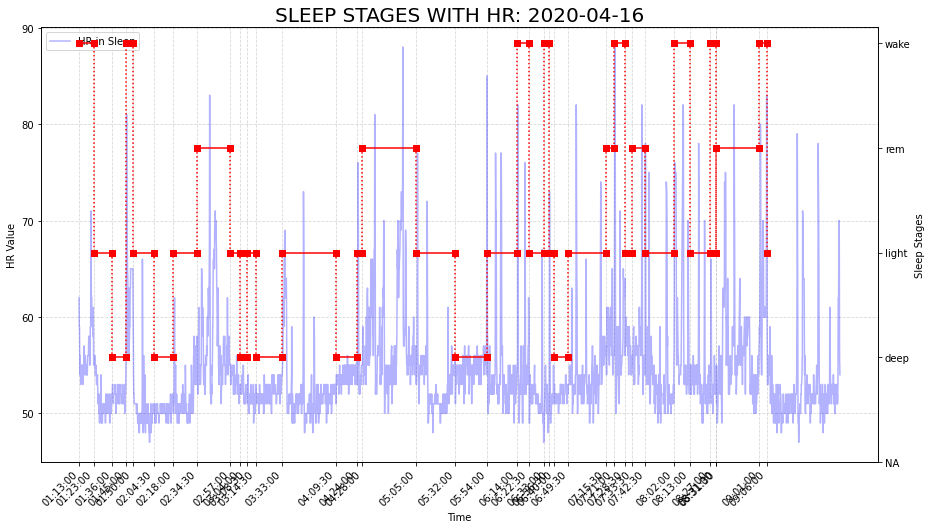

In [40]:
# Intra-Day Heart Rate at Detailed Sleep Stages

def convert_stage(x):
    if x == 'wake':
        return 3.0
    elif x == 'rem':
        return 2.0
    elif x == 'light':
        return 1.0
    elif x == 'deep':
        return 0.0
    else: return -1.0

select_date = '2020-04-16' # Change date here

START = str(PERSON1.df_sleep_durations.loc[select_date].startTime)
END = str(PERSON1.df_sleep_durations.loc[select_date].endTime)

# Fetching HR during the Sleep duration (within StartTime and EndTime):
SleepHR = PERSON1.df_intraday_hr[START:END]

# Plotting HR :
# SleepHR['value'].plot(figsize=(15,8),color='b',label='HR in Sleep')
plt.figure(figsize=(15,8))
plt.plot(SleepHR.index.astype(int),SleepHR.value,color='b',alpha=0.3,label='HR in Sleep')

plt.title('SLEEP STAGES WITH HR: '+ select_date,fontdict={'fontsize':20})
plt.grid(True,alpha=0.5,ls='--')
plt.xlabel('Time')
plt.ylabel('HR Value')
plt.legend(loc='upper left')

# Plotting Sleep Stage:

SleepStage = PERSON1.df_intra_sleep_stage[PERSON1.df_intra_sleep_stage.dateOfSleep == select_date]

# Create a list to plot lines for the different sleep stages.
index_list = SleepStage.index.astype(int).to_list()

plt.xticks(ticks=index_list, labels=SleepStage.time, rotation=45, ha='right')

y_values = SleepStage.level.apply(convert_stage)

ax2 = plt.twinx() # Create another axis 

for i in range(0,len(SleepStage)-1):
    
    # actual Sleep stage duration:
    line_x = [index_list[i],index_list[i+1]]
    line_y = [y_values.iloc[i],y_values.iloc[i]]
    
    # Transition to next stage:
    line_x1 = [index_list[i+1],index_list[i+1]]
    line_y1 = [y_values.iloc[i],y_values.iloc[i+1]]

    ax2.plot(line_x,line_y,'s-r') # Solid line
    ax2.plot(line_x1,line_y1,'s:r') # Dotted line

plt.ylabel('Sleep Stages')
plt.yticks(ticks= [-1,0,1,2,3], labels= ['NA','deep','light','rem','wake'])

plt.show()

The Last point of the sleep stage will last till the end of the sleep.

From the above plot in contrast, it is observable that:
- Heart Rate seems to have little variation when in Deep sleep 
- Heart Rate seem to rise, with rapid changes when in REM stage
- Heart Rate does not point out when user is awake, most probably deteced when Movement is sensed.
- Light Sleep makes up the rest of the non catagorised.

#### Sleep Duration and Efficiency

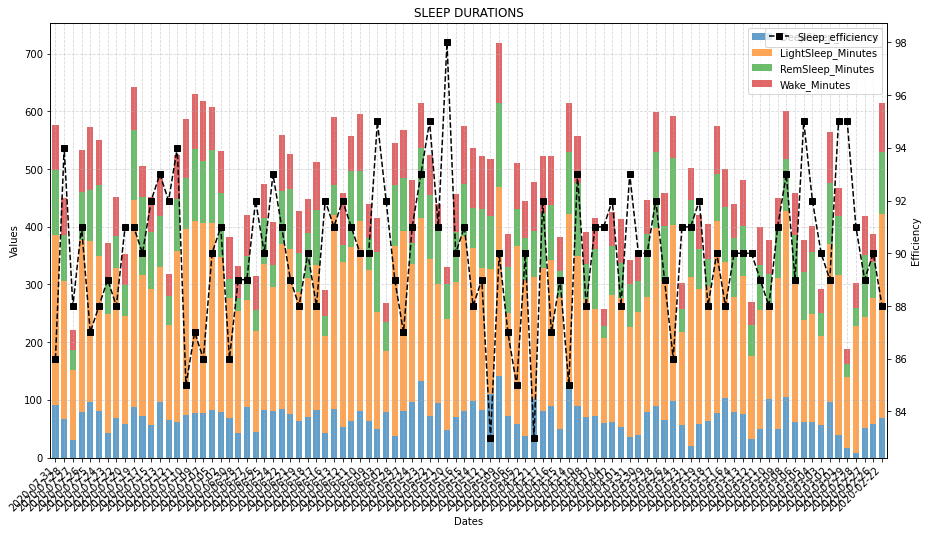

In [41]:
# Plotting Sleep Durations and efficiency using df.plot()

col = [x for x in PERSON1.df_sleep_durations.columns if 'minutes' in x.lower() and 'minutesAsleep' not in x]

PERSON1.df_sleep_durations[col].plot(kind='bar',figsize=(15,8),stacked=True,width=0.7,alpha=0.7)

plt.grid(True,alpha=0.5,ls='--')
plt.title('SLEEP DURATIONS')
plt.xticks(rotation=45,ha='right')
plt.xlabel('Dates')
plt.ylabel('Values')

ax2 = plt.twinx() # Create another axis to display Sleep efficiency
ax2.set_ylabel('Efficiency')
ax2.plot(PERSON1.df_sleep_durations.index, PERSON1.df_sleep_durations.sleep_efficiency, 
         '--sk',label='Sleep_efficiency')

ax2.legend()

plt.show()

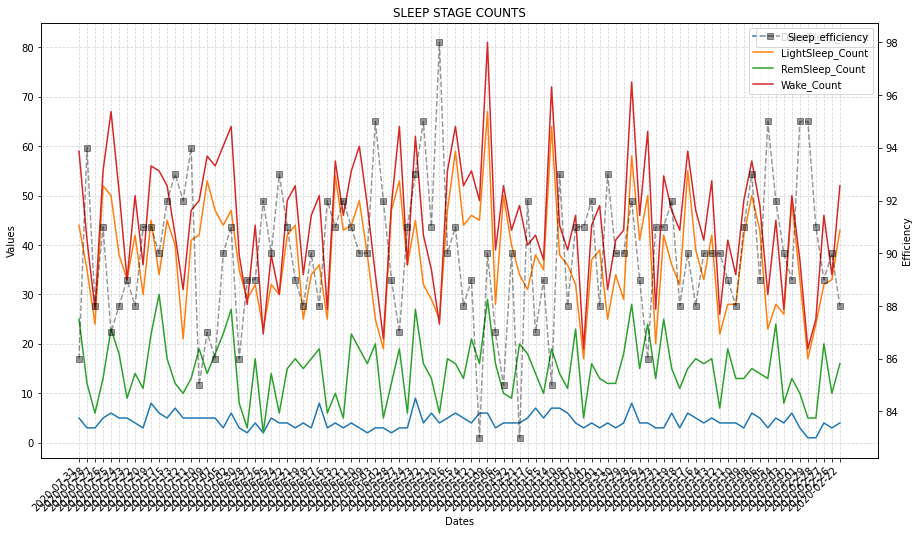

In [42]:
# Plotting Sleep Stage counts with efficiency using df.plot()

col = [x for x in PERSON1.df_sleep_durations.columns if 'Count' in x ]

PERSON1.df_sleep_durations[col].plot(figsize=(15,8))

plt.grid(True,alpha=0.5,ls='--')
plt.title('SLEEP STAGE COUNTS')
plt.xticks(rotation=45,ha='right')
plt.xlabel('Dates')
plt.ylabel('Values')

ax2 = plt.twinx() # Create another axis to display Sleep efficiency
ax2.set_ylabel('Efficiency')
ax2.plot(PERSON1.df_sleep_durations.index, PERSON1.df_sleep_durations.sleep_efficiency, 
         '--sk', alpha=0.4,label='Sleep_efficiency')
ax2.legend()

plt.show()

From the above plots:
1. The total sleep duration consist of mostly "Light" sleep.
2. The amount of deep sleep is the lowest.
3. Generally, the sleep efficiency reported by FitBit increases when the amount of sleep increase and amount of wake reduces. No clear relations with Quality of sleep, ie. from the sleep stages "Light", "Rem" and "Deep".


#### Trends for sleep duaration by months:

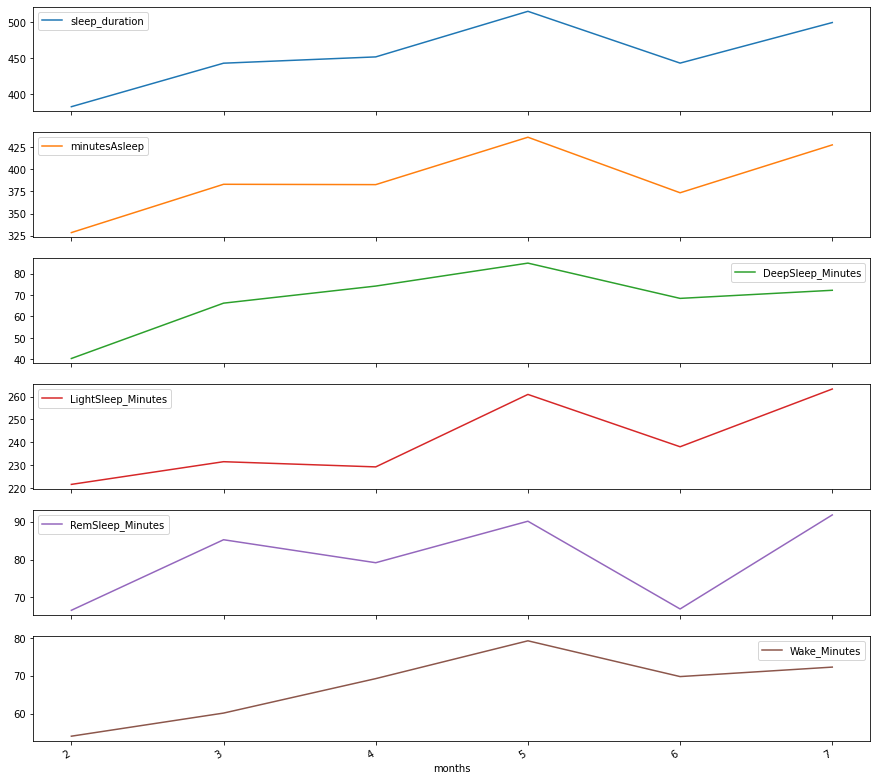

In [43]:
# Trends for Sleep Durations by months:

col = [x for x in PERSON1.df_sleep_durations.columns if 'minutes' in x.lower() or 'duration' in x.lower()]

PERSON1.df_sleep_durations.index = pd.to_datetime(PERSON1.df_sleep_durations.index)

# Splitting by months:
PERSON1.df_sleep_durations['months'] = PERSON1.df_sleep_durations.index.month

PERSON1.df_sleep_durations.groupby('months')[col].mean().plot(figsize=(15,15), subplots=True)

plt.show()

From the above plots, the average duration of sleep has increased over the months.

In [44]:
# Viewing number of records for each month:
PERSON1.df_sleep_durations.groupby('months').count()

sleep_duration  minutesAsleep  sleep_efficiency  startTime  endTime  \
months                                                                        
2                    5              5                 5          5        5   
3                   25             25                25         25       25   
4                   12             12                12         12       12   
5                   15             15                15         15       15   
6                   19             19                19         19       19   
7                   20             20                20         20       20   

        DeepSleep_Count  DeepSleep_Minutes  LightSleep_Count  \
months                                                         
2                     5                  5                 5   
3                    25                 25                25   
4                    12                 12                12   
5                    15                 15                15   
6                    19                 19                19   
7                    20                 20                20   

        LightSleep_Minutes  RemSleep_Count  RemSleep_Minutes  Wake_Count  \
months                                                                     
2                        5               5                 5           5   
3                       25              25                25          25   
4                       12              12                12          12   
5                       15              15                15          15   
6                       19              19                19          19   
7                       20              20                20          20   

        Wake_Minutes  
months                
2                  5  
3                 25  
4                 12  
5                 15  
6                 19  
7                 20

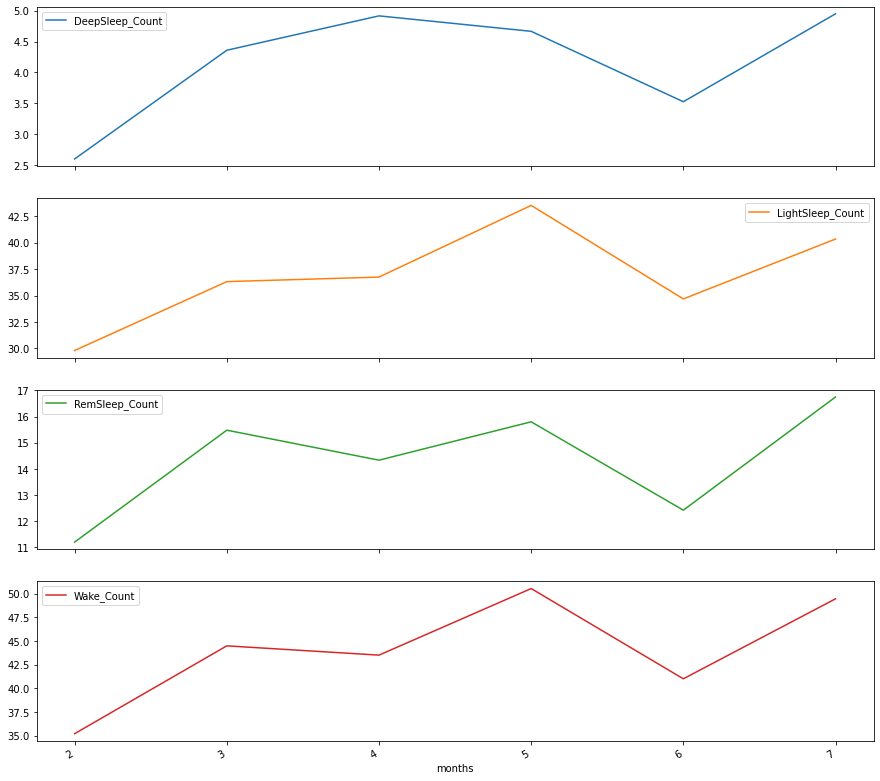

In [45]:
# Trends for Sleep stage counts by months:

col = [x for x in PERSON1.df_sleep_durations.columns if 'count' in x.lower()]

PERSON1.df_sleep_durations.index = pd.to_datetime(PERSON1.df_sleep_durations.index)

# Splitting by months:
PERSON1.df_sleep_durations['months'] = PERSON1.df_sleep_durations.index.month

PERSON1.df_sleep_durations.groupby('months')[col].mean().plot(figsize=(15,15), subplots=True)

plt.show()

Shown above, the number of sleep stage counts had also increased over the months. This is due to the sleep durations getting long, allowing more sleep stages to take place.

June drops for both sleep duration and counts.

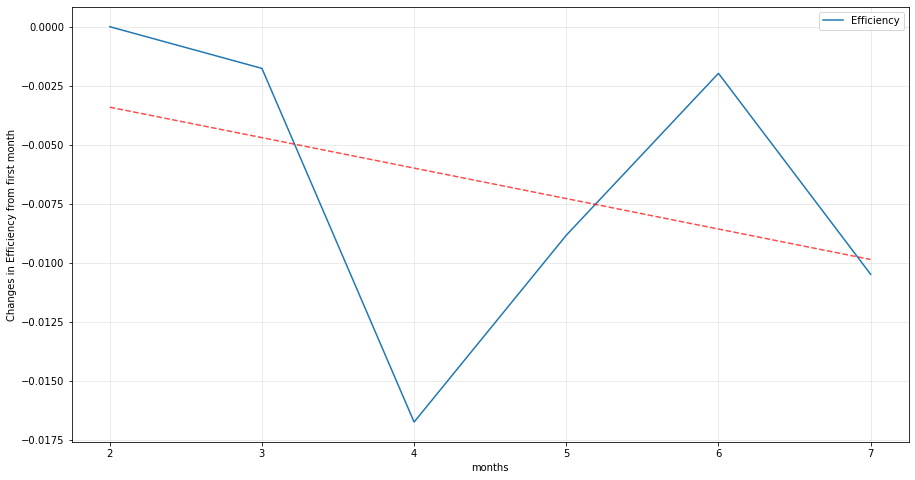

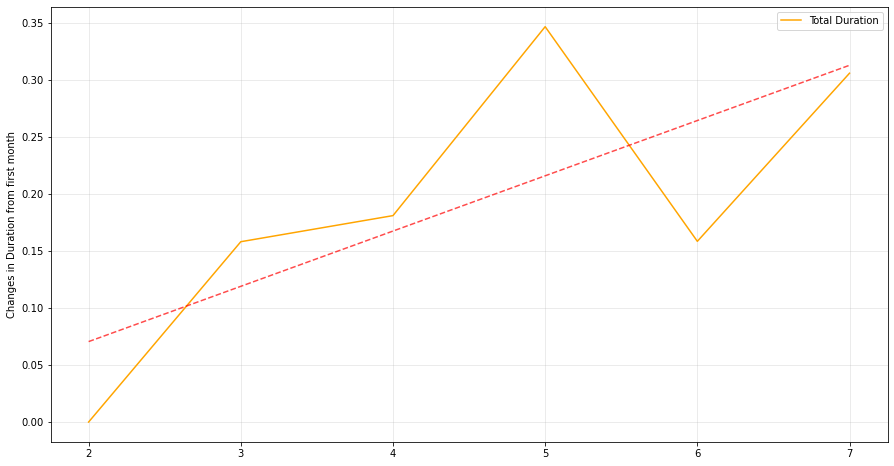

In [46]:
# Trends for Sleep duration and efficiency by months:

PERSON1.df_sleep_durations.index = pd.to_datetime(PERSON1.df_sleep_durations.index)

# Splitting by months:
PERSON1.df_sleep_durations['months'] = PERSON1.df_sleep_durations.index.month

# Changes as percentage changes from the first month:
diff_efficiency = PERSON1.df_sleep_durations.groupby('months')['sleep_efficiency'].mean()
diff_efficiency = diff_efficiency.apply(lambda x:(x-diff_efficiency.iloc[0])/diff_efficiency.iloc[0])

diff_durations = PERSON1.df_sleep_durations.groupby('months')['sleep_duration'].mean()
diff_durations = diff_durations.apply(lambda x:(x-diff_durations.iloc[0])/diff_durations.iloc[0])

# Linear Regression Fit for trendline:
lm_efficiency = lm.LinearRegression()
lm_efficiency.fit(diff_efficiency.index.to_numpy().reshape(-1, 1),
                  diff_efficiency.to_numpy().reshape(-1, 1))
pred_efficiency = lm_efficiency.predict(diff_efficiency.index.to_numpy().reshape(-1, 1))

lm_durations = lm.LinearRegression()
lm_durations.fit(diff_durations.index.to_numpy().reshape(-1, 1),
                  diff_durations.to_numpy().reshape(-1, 1))
pred_durations = lm_durations.predict(diff_durations.index.to_numpy().reshape(-1, 1))


# Plotting:
diff_efficiency.plot(figsize=(15,8),label="Efficiency")
plt.plot(diff_efficiency.index.to_numpy(),pred_efficiency,'--r',alpha=0.7)
plt.ylabel("Changes in Efficiency from first month")
plt.grid(":",alpha=0.3,axis="both")
plt.legend()
plt.show()

plt.figure(figsize=(15,8))
plt.plot(diff_durations,label="Total Duration",color='orange')
plt.plot(diff_durations.index.to_numpy(),pred_durations,'--r',alpha=0.7)
plt.ylabel("Changes in Duration from first month")
plt.grid(":",alpha=0.3,axis="both")
plt.legend()
plt.show()


In comparison of the above graph, sleep efficiency does not change much accordingly to how long the total sleep duration is. As the Sleep duration increased from FEB to JUL, the efficiency drops.

#### Trends for sleep time

In [47]:
PERSON1.df_sleep_durations.startTime

dateOfSleep
2020-07-31   2020-07-31 00:22:00
2020-07-28   2020-07-27 23:15:30
2020-07-27   2020-07-27 06:01:00
2020-07-26   2020-07-26 00:02:00
2020-07-25   2020-07-25 02:41:30
                     ...        
2020-02-29   2020-02-29 07:10:30
2020-02-28   2020-02-28 02:05:30
2020-02-27   2020-02-27 00:03:00
2020-02-26   2020-02-26 00:34:00
2020-02-22   2020-02-21 23:25:00
Name: startTime, Length: 96, dtype: datetime64[ns]

The date of sleep is always the following day.

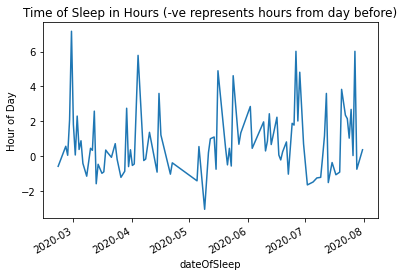

In [48]:
# Check if Start Time is on the same day of DateOfSleep:
check = PERSON1.df_sleep_durations.startTime >= pd.DatetimeIndex(PERSON1.df_sleep_durations.index)

# minus 24h if start time is not the DateOfSleep:
hour_of_sleep = PERSON1.df_sleep_durations[~check].startTime.dt.hour - 24.0
hour_of_sleep = pd.concat([hour_of_sleep,PERSON1.df_sleep_durations[check].startTime.dt.hour])

time_of_sleep = hour_of_sleep.sort_index() + PERSON1.df_sleep_durations.startTime.sort_index().dt.minute / 60.0

time_of_sleep.plot()

plt.title("Time of Sleep in Hours (-ve represents hours from day before)")
plt.ylabel("Hour of Day")

plt.show()

Time of Sleep By Months:

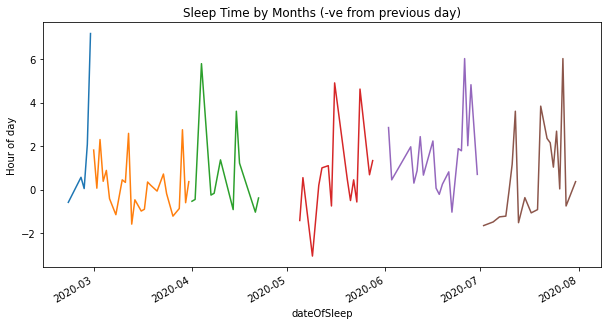

In [49]:
time_grpby_month = PERSON1.df_sleep_durations.sort_index()
time_grpby_month['HourOfSleep'] = time_of_sleep
time_grpby_month = time_grpby_month.groupby('months')

plt.figure(figsize=(10,5))
time_grpby_month['HourOfSleep'].plot()
plt.title("Sleep Time by Months (-ve from previous day)")
plt.ylabel("Hour of day")

plt.show()


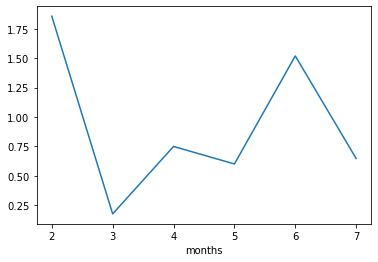

In [50]:
time_grpby_month['HourOfSleep'].mean().plot()

#### Resting Heart Rate

In [51]:
PERSON1.df_resting_hr

restingHeartRate
dateTime                    
2020-02-21              64.0
2020-02-22              58.0
2020-02-23              59.0
2020-02-24              59.0
2020-02-25              59.0
...                      ...
2020-07-27              58.0
2020-07-28              58.0
2020-07-29              59.0
2020-07-30              60.0
2020-07-31              62.0

[128 rows x 1 columns]

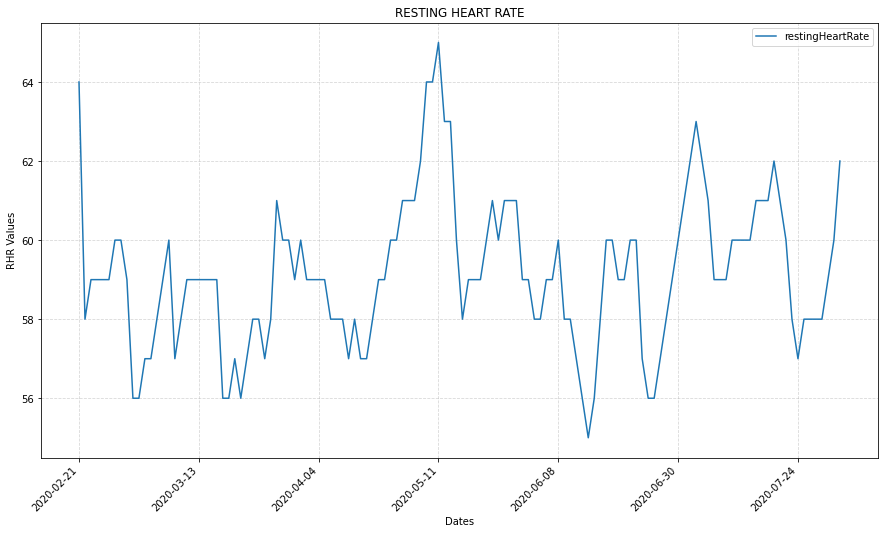

In [52]:
# Plotting Heart Rate and efficiency using df.plot()

PERSON1.df_resting_hr.plot(figsize=(15,8))


plt.grid(True,alpha=0.5,ls='--')
plt.title('RESTING HEART RATE')
plt.xticks(rotation=45,ha='right')
plt.xlabel('Dates')
plt.ylabel('RHR Values')

plt.show()

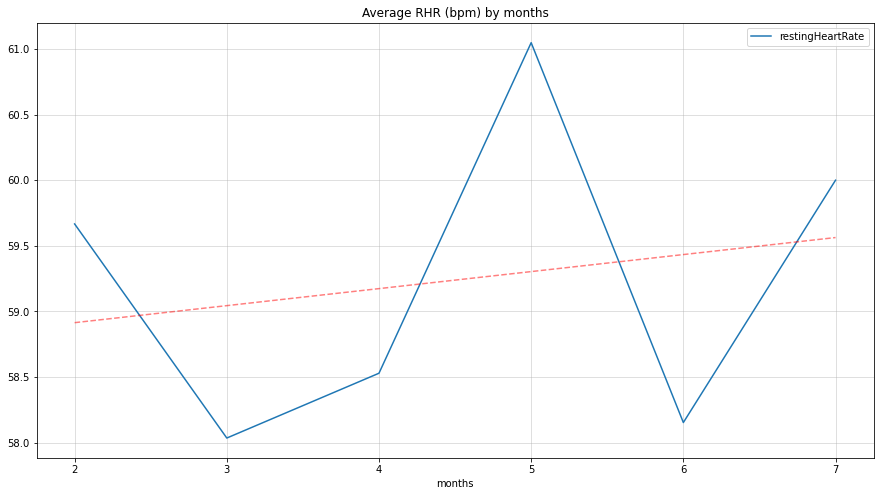

In [53]:
PERSON1.df_resting_hr.index = pd.to_datetime(PERSON1.df_resting_hr.index)

PERSON1.df_resting_hr['months'] = PERSON1.df_resting_hr.index.month

RHR_Mean_Grouped = PERSON1.df_resting_hr.groupby('months').mean()

RHR_Mean_Grouped.plot(figsize=(15,8))

# Linear Regression Fit for trendline:
lm_rhr = lm.LinearRegression()
lm_rhr.fit(RHR_Mean_Grouped.index.to_numpy().reshape(-1, 1),
                  RHR_Mean_Grouped.to_numpy().reshape(-1, 1))
pred_rhr = lm_rhr.predict(RHR_Mean_Grouped.index.to_numpy().reshape(-1, 1))

plt.plot(RHR_Mean_Grouped.index,pred_rhr,'--r',alpha=0.5)

plt.title('Average RHR (bpm) by months')

plt.grid(':',alpha=0.5)

plt.show()

From the linear trendline above, RHR increases from FEB to JUL. The RHR goes up and down. however, compared to other indicatiors like calories, MAY was also significantly higher than the rest of the months.

In [54]:
# Viewing the number of records in each month:

PERSON1.df_resting_hr.groupby('months').count()

restingHeartRate
months                  
2                      9
3                     28
4                     17
5                     21
6                     26
7                     27

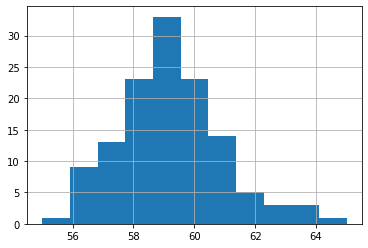

In [55]:
# DISTRIBUTION OF RHR:

PERSON1.df_resting_hr.restingHeartRate.hist(bins=11)
plt.show()

The distribution for the RHR seems to follow something like a normal distribution also.

### Steps Activity and RHR relationship

In [56]:
PERSON1.df_activity_steps

step_count  month     m_num
dateTime                               
2020-02-21       12981      2  February
2020-02-22       12802      2  February
2020-02-23        9030      2  February
2020-02-24       15361      2  February
2020-02-25       12570      2  February
...                ...    ...       ...
2020-07-27       14356      7      July
2020-07-28        8149      7      July
2020-07-29       13651      7      July
2020-07-30       10888      7      July
2020-07-31        9727      7      July

[118 rows x 3 columns]

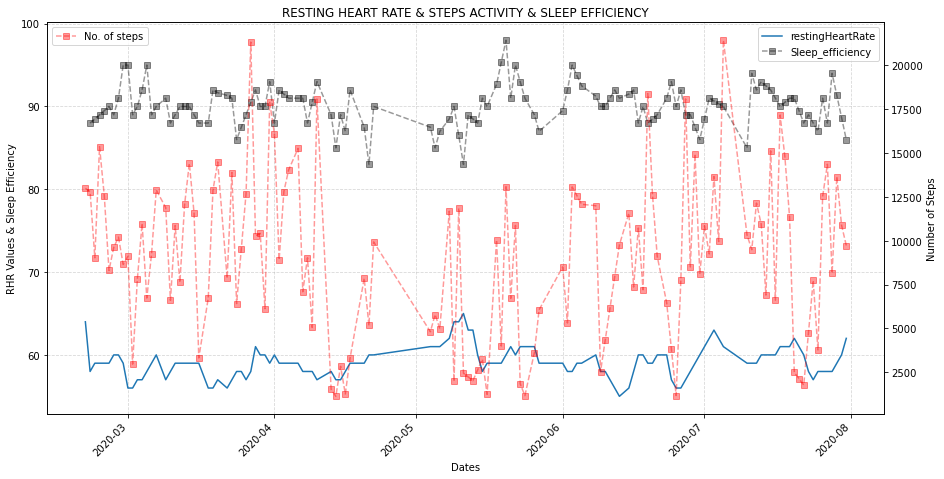

In [57]:
# Plotting RHR and Sleep Efficiency time series using df.plot()

PERSON1.df_resting_hr.restingHeartRate.plot(figsize=(15,8))

plt.plot(PERSON1.df_sleep_durations.reindex(PERSON1.df_resting_hr.index).index,
         PERSON1.df_sleep_durations.reindex(PERSON1.df_resting_hr.index).interpolate().sleep_efficiency, 
         '--sk', alpha=0.4,label='Sleep_efficiency')
plt.legend()
plt.grid(True,alpha=0.5,ls='--')
plt.title('RESTING HEART RATE & STEPS ACTIVITY & SLEEP EFFICIENCY')
plt.xticks(rotation=45,ha='right')
plt.xlabel('Dates')
plt.ylabel('RHR Values & Sleep Efficiency')

ax2 = plt.twinx() # Create another axis to display Steps Data for additional comparison
ax2.set_ylabel('Number of Steps')
ax2.plot(PERSON1.df_activity_steps.reindex(PERSON1.df_resting_hr.index).index,
         PERSON1.df_activity_steps.reindex(PERSON1.df_resting_hr.index).interpolate().step_count, 
         '--sr', alpha=0.4,label='No. of steps')
ax2.legend(loc='upper left')

plt.show()

### Heart Rate Variability

In [58]:
PERSON1.df_hrv_stats_full_day

Max_PP_interval  Min_PP_interval  SD_PP_interval  \
date                                                           
2020-02-26      1276.595745       500.000000      162.551351   
2020-02-27      1304.347826       441.176471      176.099620   
2020-02-28      1250.000000       458.015267      146.807368   
2020-02-29      1276.595745       410.958904      147.758691   
2020-03-01      1304.347826       472.440945      198.042279   
...                     ...              ...             ...   
2020-07-25      1304.347826       402.684564      158.043198   
2020-07-26      1428.571429       447.761194      221.390249   
2020-07-27      1276.595745       437.956204      166.500560   
2020-07-28      1304.347826       458.015267      167.141707   
2020-07-31      1250.000000       483.870968      148.105529   

            Mean_PP_interval  PP_interval_range  SD_PP_5min  RMS_PP_diff  \
date                                                                       
2020-02-26        899.645812         776.595745  152.288575    22.161224   
2020-02-27        876.242585         863.171355  166.404115    22.293061   
2020-02-28        873.208981         791.984733  135.206961    22.197500   
2020-02-29        883.056559         865.636841  137.317821    18.601153   
2020-03-01        936.929742         831.906881  188.219051    23.006086   
...                      ...                ...         ...          ...   
2020-07-25       1004.586109         901.663262  144.952437    26.986297   
2020-07-26        961.160662         980.810235  213.630667    23.318217   
2020-07-27        852.129840         838.639540  157.425040    21.144231   
2020-07-28        934.817974         846.332559  156.072464    23.790994   
2020-07-31        885.076459         766.129032  134.909626    27.060121   

            Max_PP_1st_dydt  SD_PP_1st_dydt  Max_PP_2nd_dydt  SD_PP_2nd_dydt  
date                                                                          
2020-02-26        69.707401        3.844838        11.919612        0.751220  
2020-02-27        68.607069        3.810468        13.721414        0.742067  
2020-02-28        60.555088        3.830093        11.904762        0.756564  
2020-02-29        56.390977        3.286330        11.076923        0.639132  
2020-03-01        94.897959        3.948118        18.979592        0.808380  
...                     ...             ...              ...             ...  
2020-07-25        66.415094        4.533282        13.283019        0.873019  
2020-07-26        62.031533        3.950721        12.406307        0.772212  
2020-07-27        70.323488        3.637569        14.064698        0.719270  
2020-07-28        81.447964        4.033399        16.289593        0.790074  
2020-07-31        77.643909        4.485695        15.528782        0.866953  

[100 rows x 11 columns]

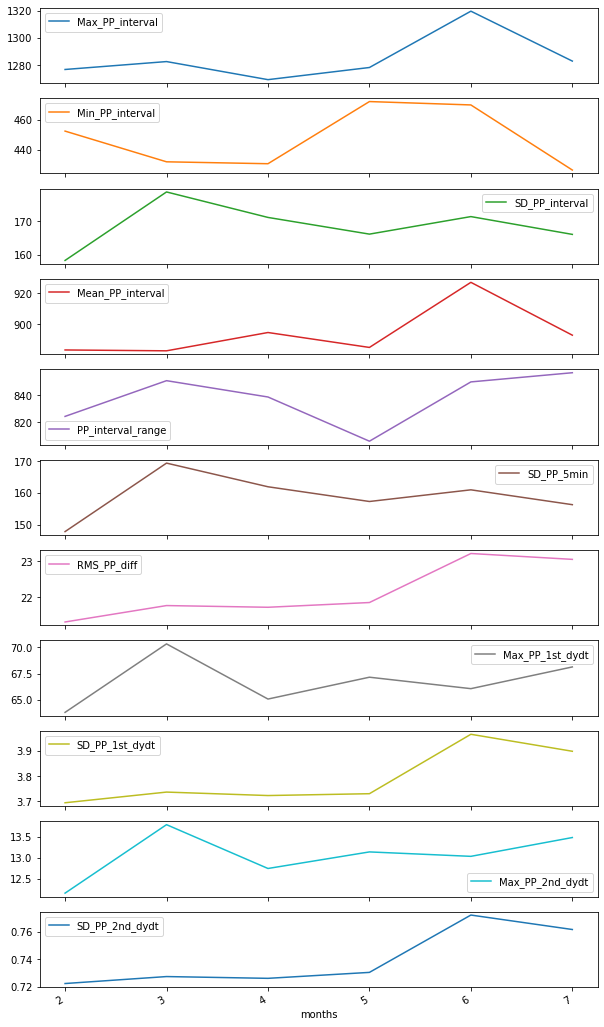

In [59]:
# SPLITTING INTO MONTHS for HRV of full day records:

PERSON1.df_hrv_stats_full_day.index = pd.to_datetime(PERSON1.df_hrv_stats_full_day.index)

PERSON1.df_hrv_stats_full_day['months'] = PERSON1.df_hrv_stats_full_day.index.month

HRV_Mean_Grouped = PERSON1.df_hrv_stats_full_day.groupby('months').mean()

HRV_Mean_Grouped.plot(figsize=(10,20),subplots=True)

plt.show()

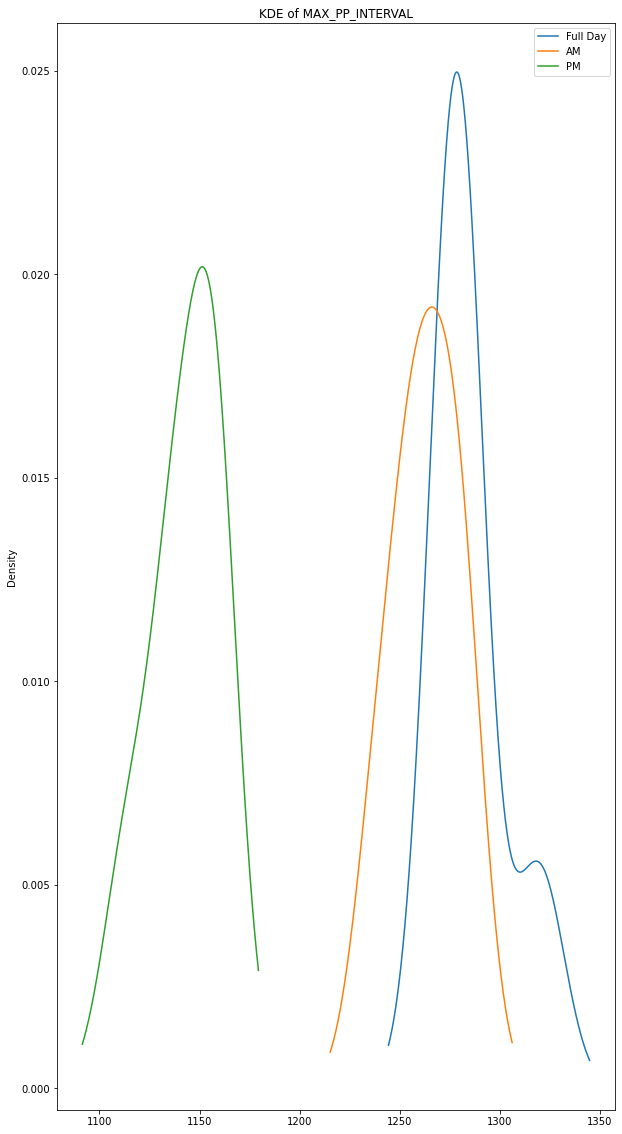

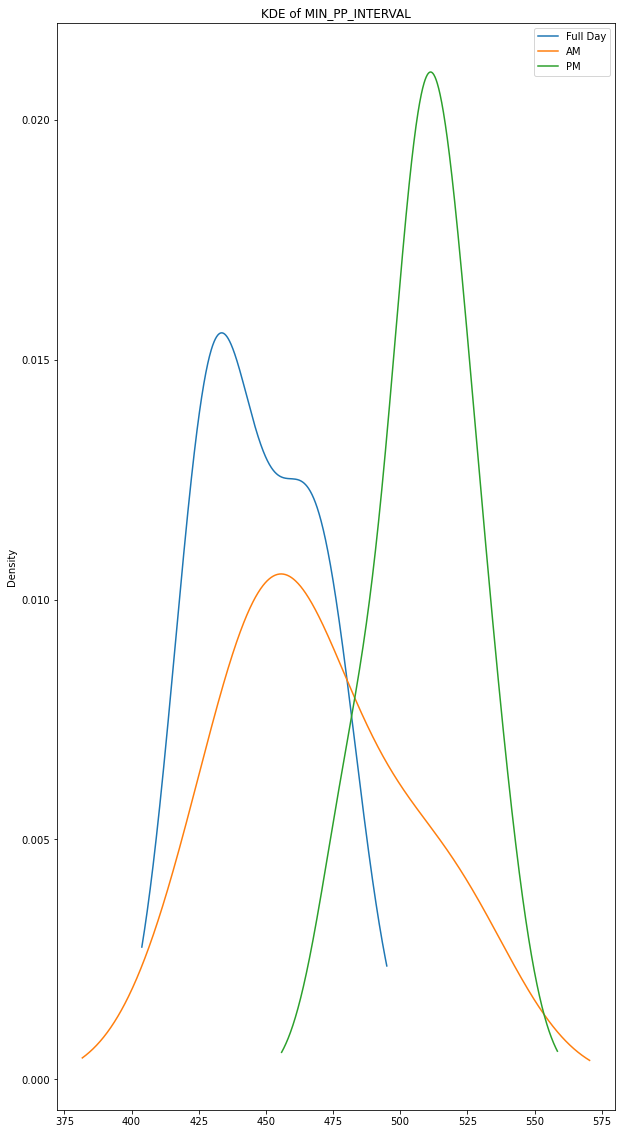

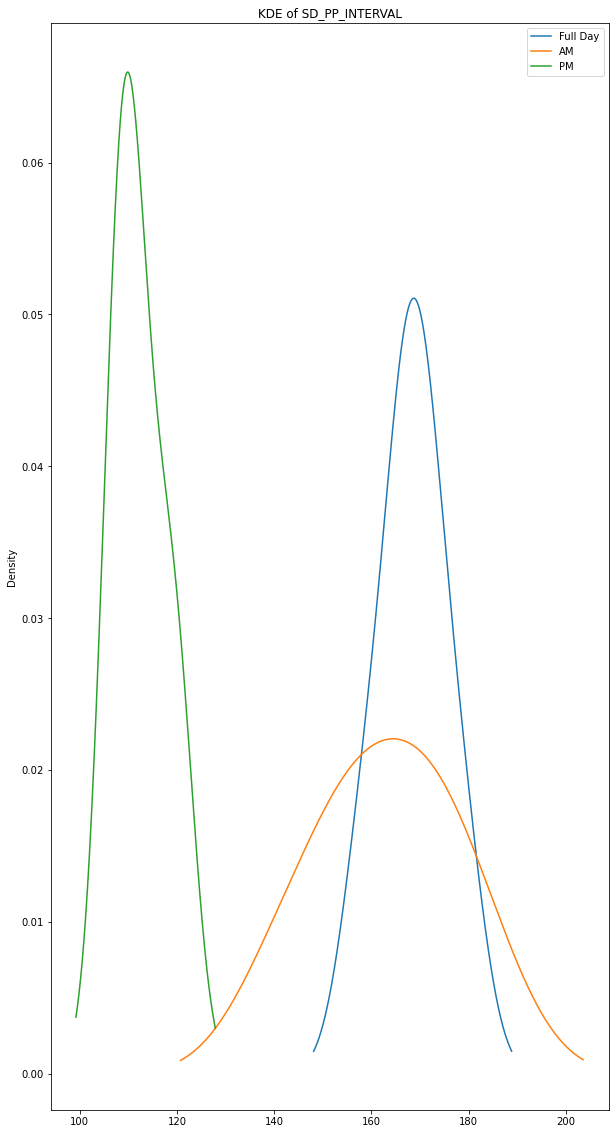

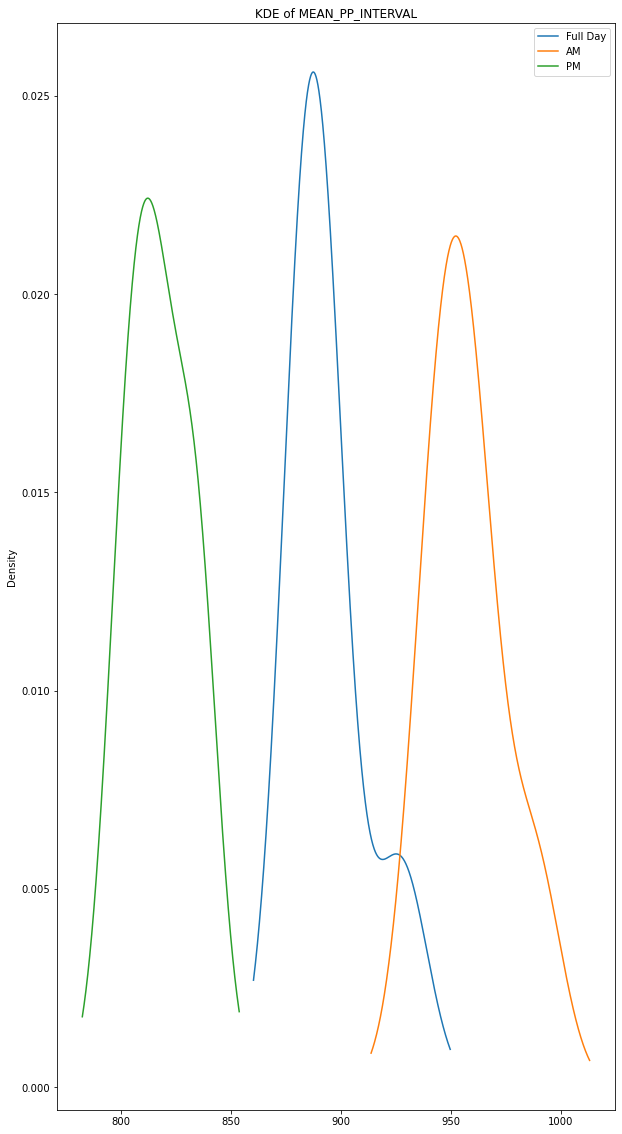

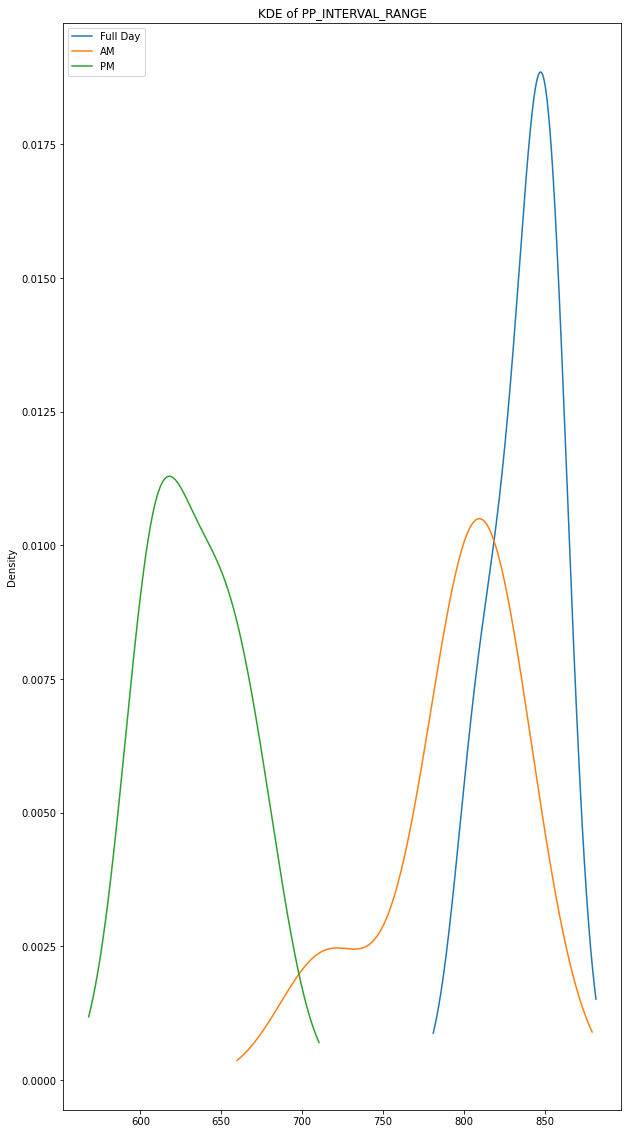

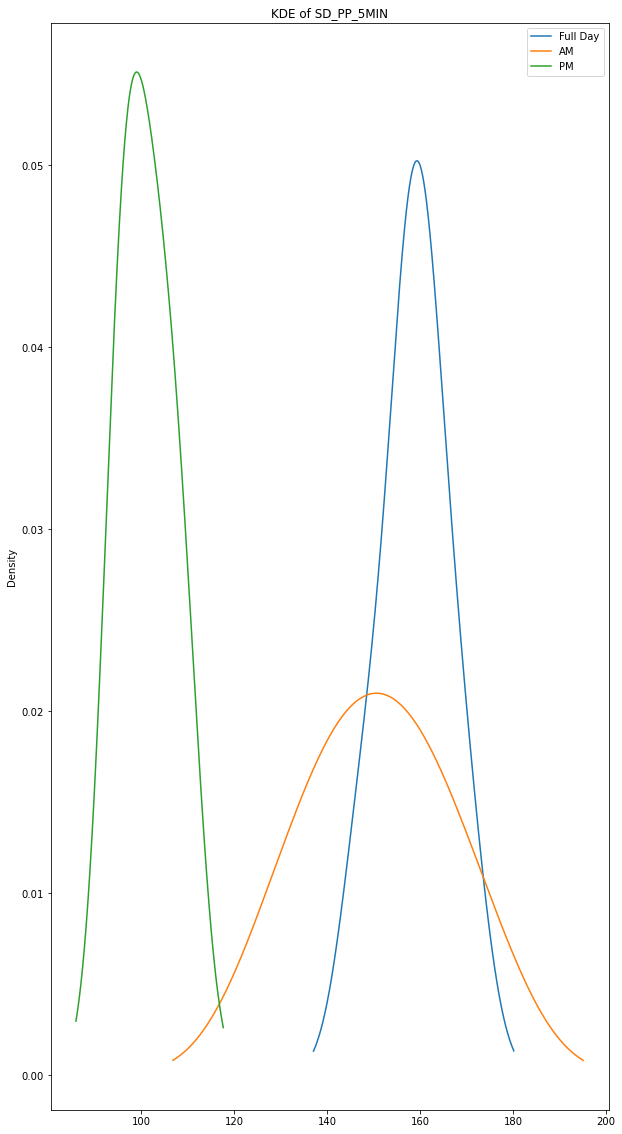

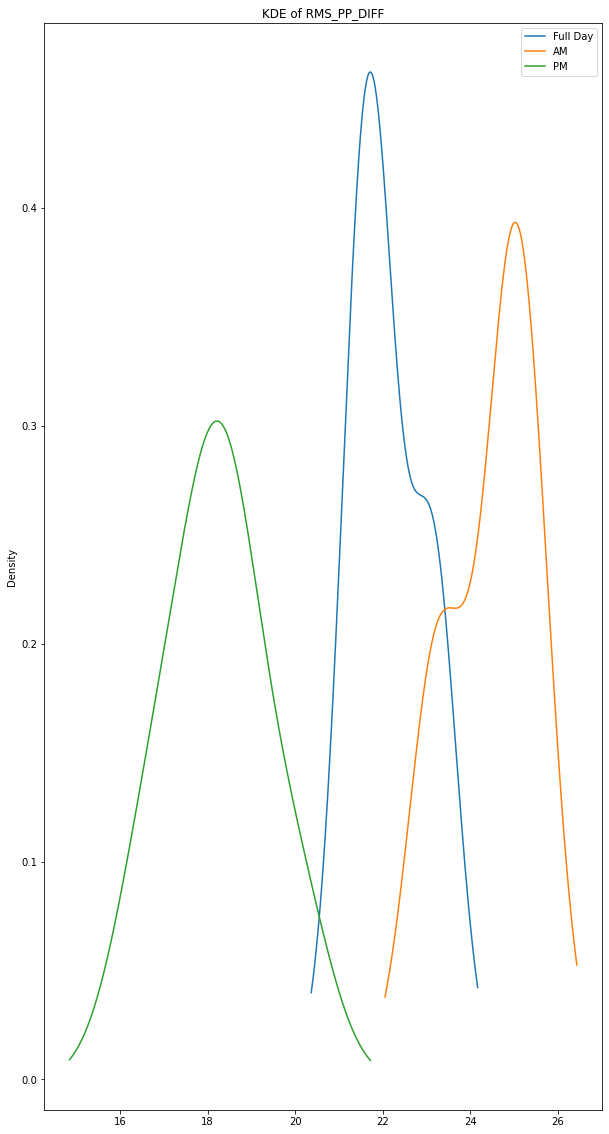

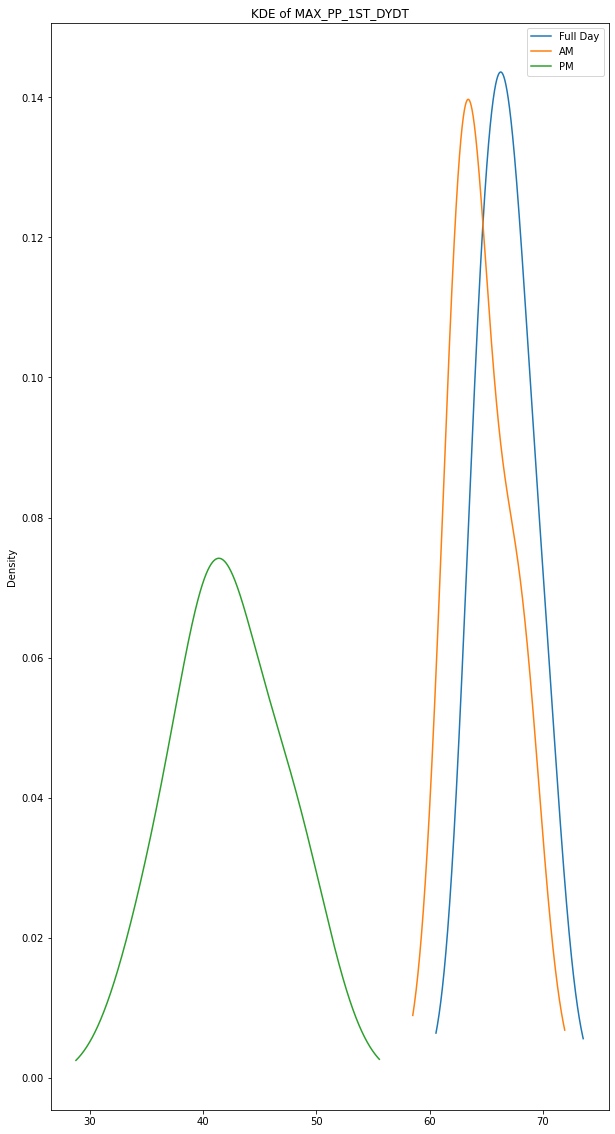

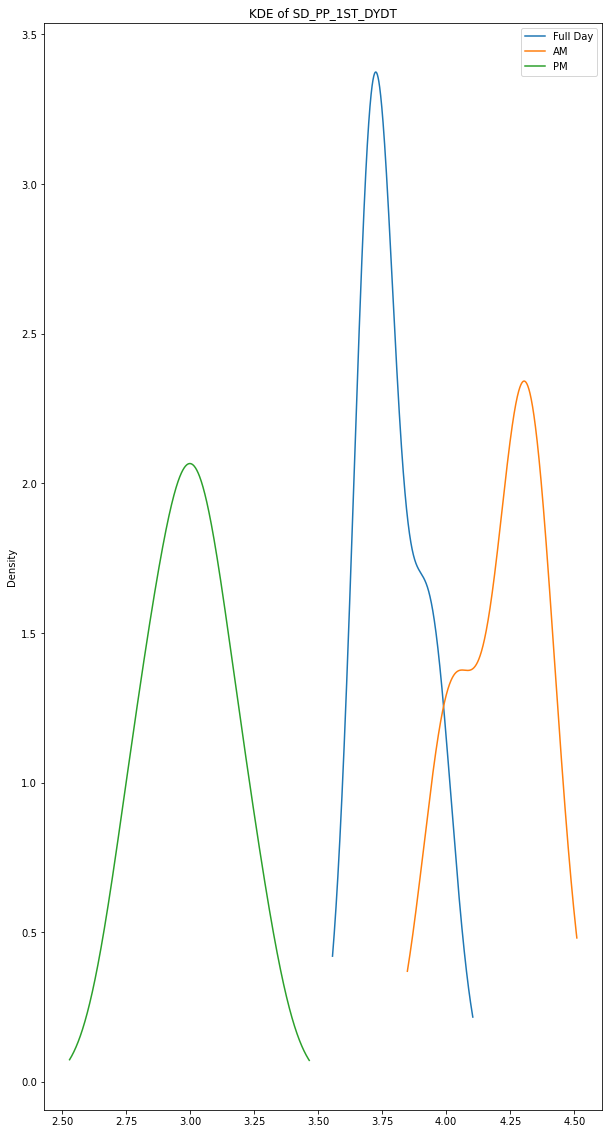

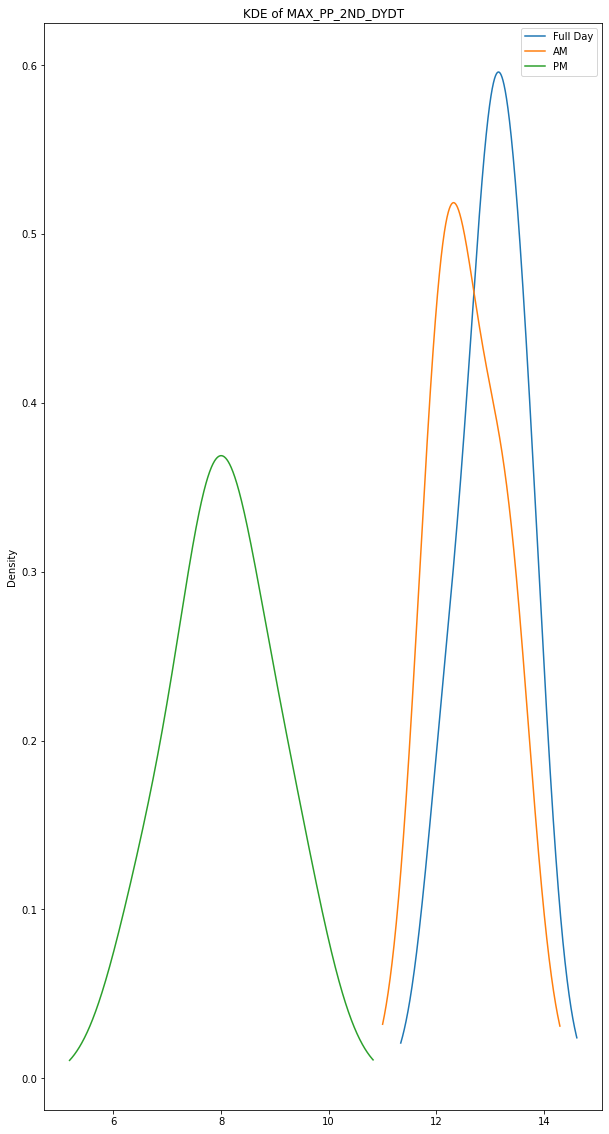

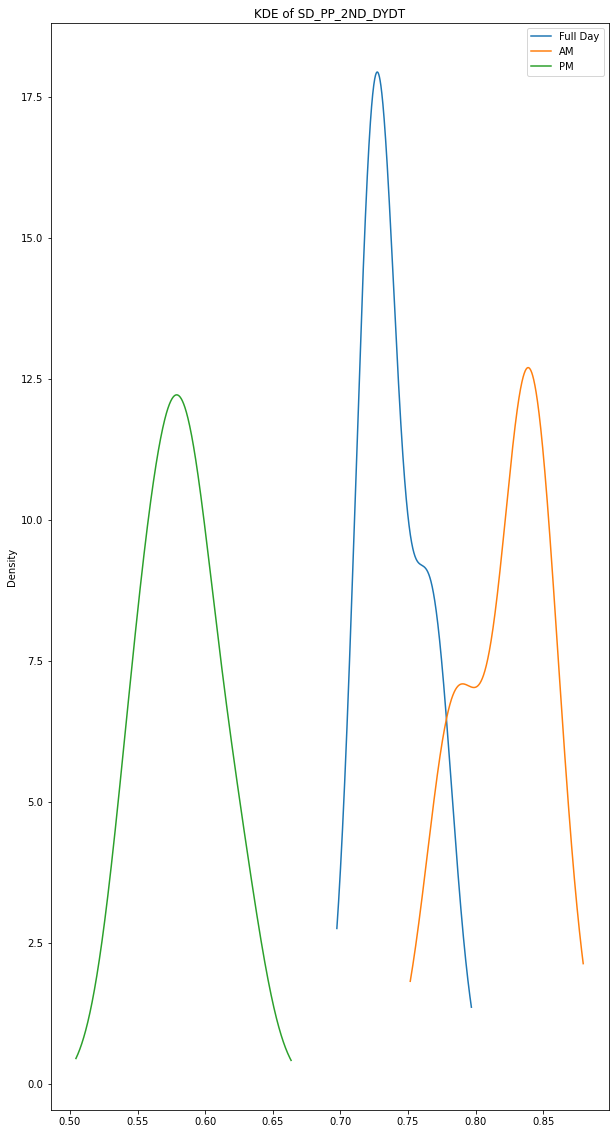

In [60]:
# SPLITTING INTO MONTHS for HRV of AM and PM half-day records:

PERSON1.df_hrv_stats_AM.index = pd.to_datetime(PERSON1.df_hrv_stats_AM.index)
PERSON1.df_hrv_stats_PM.index = pd.to_datetime(PERSON1.df_hrv_stats_PM.index)

PERSON1.df_hrv_stats_AM['months'] = PERSON1.df_hrv_stats_AM.index.month
PERSON1.df_hrv_stats_PM['months'] = PERSON1.df_hrv_stats_PM.index.month

HRV_AM_Mean_Grouped = PERSON1.df_hrv_stats_AM.groupby('months').mean()
HRV_PM_Mean_Grouped = PERSON1.df_hrv_stats_PM.groupby('months').mean()

for col_y in PERSON1.df_hrv_stats_AM.columns[0:-1]:
    plt.figure(figsize=(20,5))
    HRV_Mean_Grouped[col_y].plot(kind='kde',figsize=(10,20),label="Full Day") # plotting together for comparison
    HRV_AM_Mean_Grouped[col_y].plot(kind='kde',figsize=(10,20),label="AM")
    HRV_PM_Mean_Grouped[col_y].plot(kind='kde',figsize=(10,20),label="PM")
    plt.title("KDE of "+col_y.upper())
    plt.legend()
    
plt.show()

Comparing the HRV stats, there is a difference in time of day. in PM the stats are lower than in AM, this may be due to more activity happens in the morning, causing more variability.

### Comparing RHR / Sleep Duration / Calories when peak minutes are zero VS Where there are peak minutes

When peak minutes or cardio minutes are not present, there is a high chance that user was not exercising/aerobic activities (Jogging, running, etc) for that particular day. Thus, comparison of the two groups of data might be meaningful to see the effect on RHR.

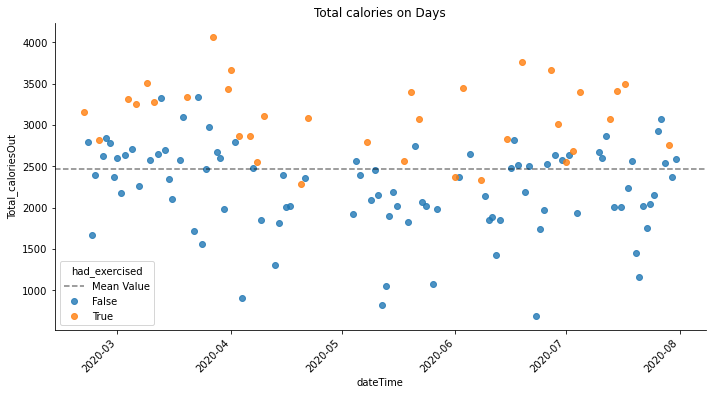

In [61]:
# Finding Days when peak minutes or cardio minutes are not present

mask = (PERSON1.df_hr_calories.minutes_Cardio != 0) & (PERSON1.df_hr_calories.minutes_Peak != 0)

PERSON1.df_hr_calories['had_exercised'] = mask

# Plot out to see the diff of total calories:
sns.lmplot('dateTime','Total_caloriesOut',data=PERSON1.df_hr_calories.reset_index(),
           fit_reg=False,hue='had_exercised',aspect=2,legend=False)

plt.axhline(PERSON1.df_hr_calories.Total_caloriesOut.mean(),linestyle='--',
            label='Mean Value',color='k',alpha=0.5)

plt.xticks(rotation=45,ha='right')
plt.title('Total calories on Days')
plt.legend(title='had_exercised')
plt.show()


On days with exercise the Total Calories are higher. The average of 2500 can be the baseline.

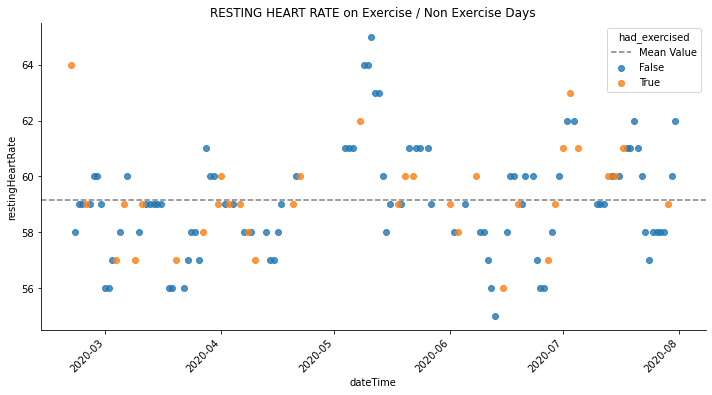

In [62]:
# Plot out to see the Diff in RHR:
combi_1 = PERSON1.df_resting_hr.restingHeartRate
combi_2 = PERSON1.df_hr_calories.had_exercised.reindex(combi_1.index) # re-index to follow RHR df records

DATA = pd.concat([combi_1,combi_2],axis=1).dropna().reset_index()

sns.lmplot('dateTime','restingHeartRate',data=DATA,
               fit_reg=False,hue='had_exercised',aspect=2,legend=False)

plt.axhline(PERSON1.df_resting_hr.restingHeartRate.mean(),linestyle='--',
            label='Mean Value',color='k',alpha=0.5)

plt.xticks(rotation=45,ha='right')
plt.title('RESTING HEART RATE on Exercise / Non Exercise Days')
plt.legend(title='had_exercised')
plt.show()


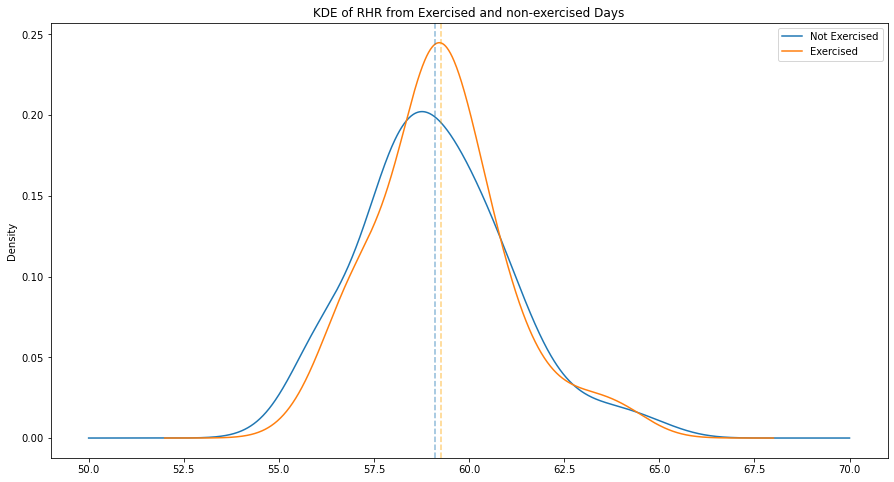

In [63]:
# Comparing the RHR (Exercised VS non-exercise) using above DATA:

plt.figure(figsize=(15,8))

DATA[DATA.had_exercised == False].restingHeartRate.plot(kind='kde',label='Not Exercised')
DATA[DATA.had_exercised == True].restingHeartRate.plot(kind='kde',label='Exercised')

plt.axvline(DATA[DATA.had_exercised == False].restingHeartRate.mean(),ls='--',alpha=0.5)
plt.axvline(DATA[DATA.had_exercised == True].restingHeartRate.mean(),c='orange',ls='--',alpha=0.5)

plt.legend()
plt.title("KDE of RHR from Exercised and non-exercised Days")
plt.show()

There was no significance difference for RHR having exercised or not. The mean RHR is a bit higher for exercised days than non-exercised days. The distribution of RHR in Non-exercised days are wider than not as sharp as the exercised days. Maybe due to lesser records for exercise.

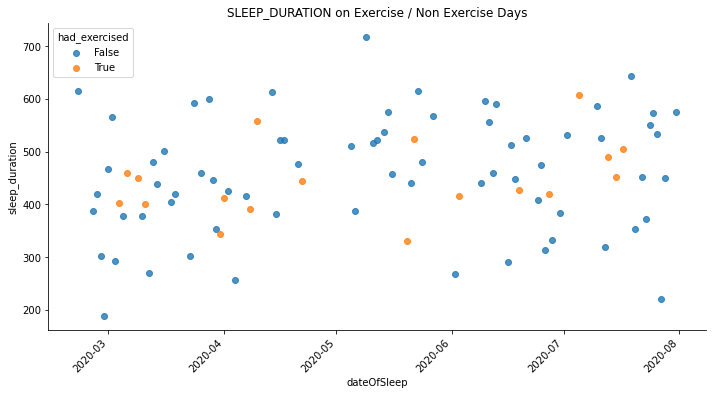

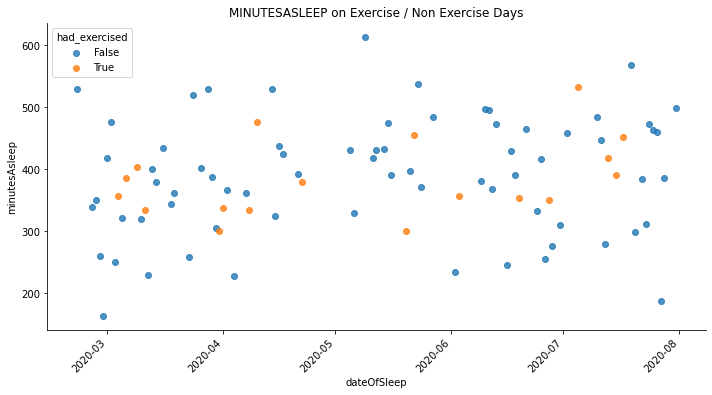

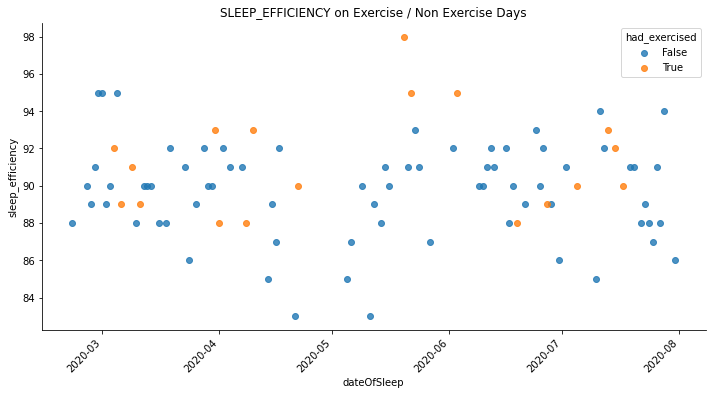

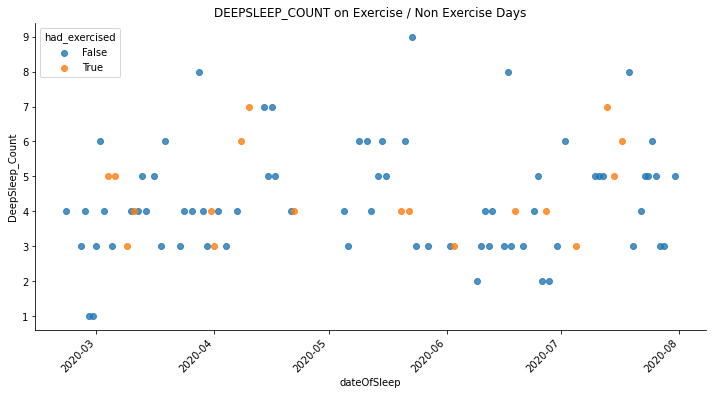

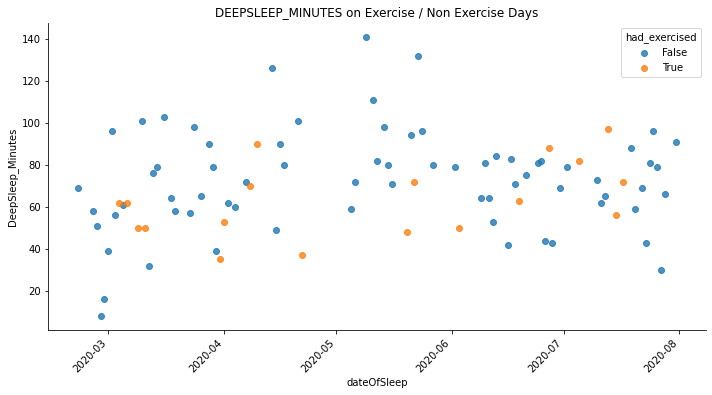

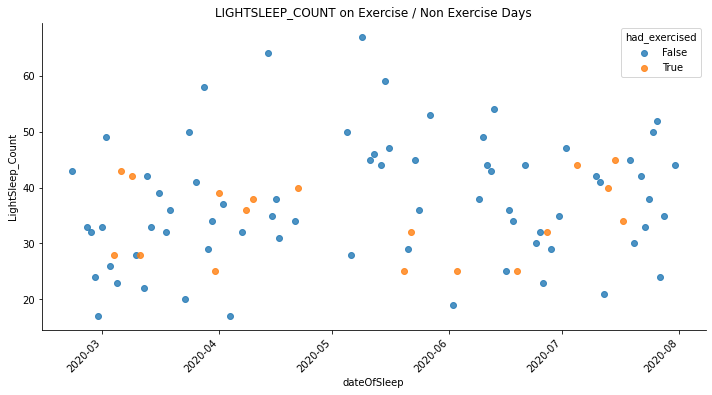

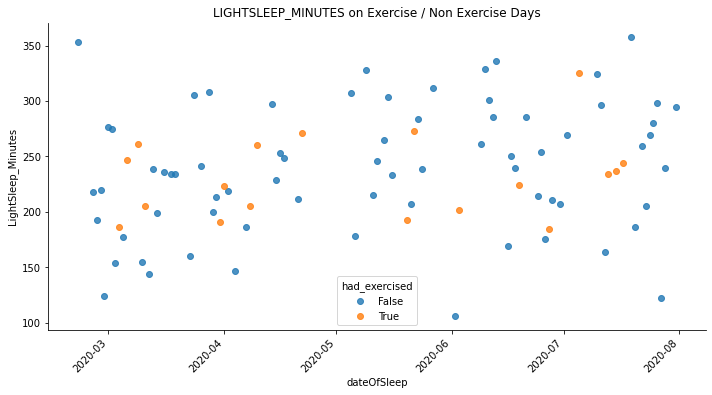

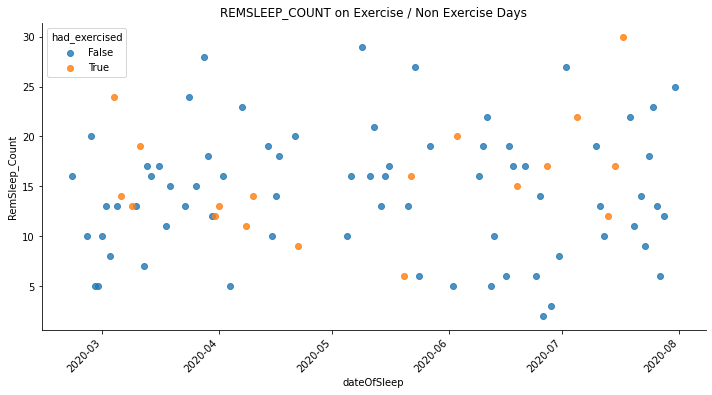

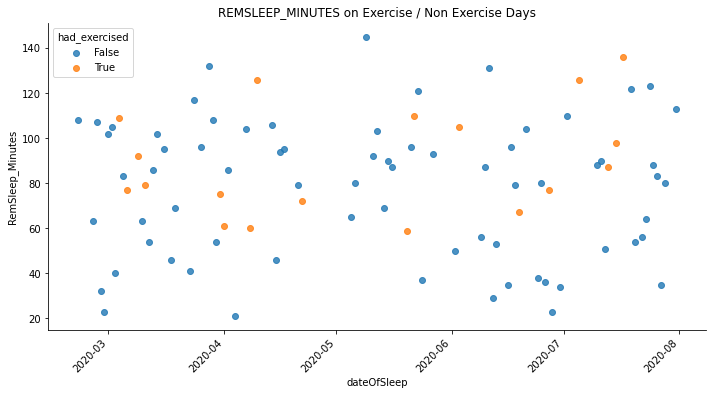

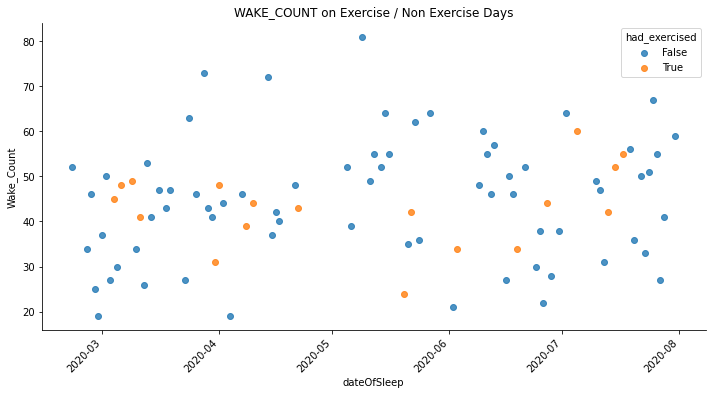

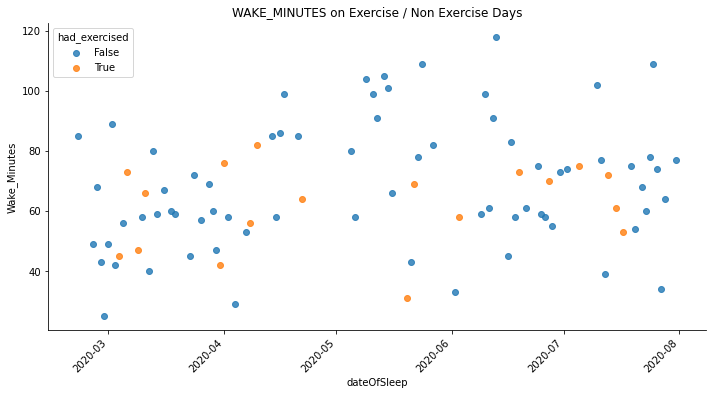

In [64]:
# Plot out to see the Diff in Sleep:

combi_1 = PERSON1.df_sleep_durations[[x for x in PERSON1.df_sleep_durations if "time" not in x.lower() and "month" not in x.lower()]]
combi_2 = PERSON1.df_hr_calories.had_exercised.reindex(combi_1.index)

DATA = pd.concat([combi_1,combi_2],axis=1).dropna().reset_index()

for col_y in combi_1.columns:
    sns.lmplot('dateOfSleep',col_y,data=DATA,
                   fit_reg=False,hue='had_exercised',aspect=2,legend=False)

    plt.xticks(rotation=45,ha='right')
    plt.title(col_y.upper() + ' on Exercise / Non Exercise Days')
    plt.legend(title='had_exercised')
    
plt.show()



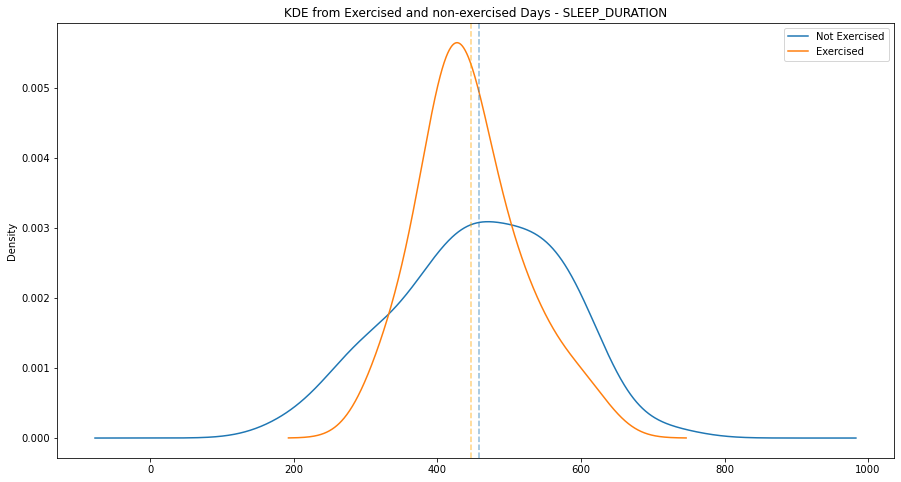

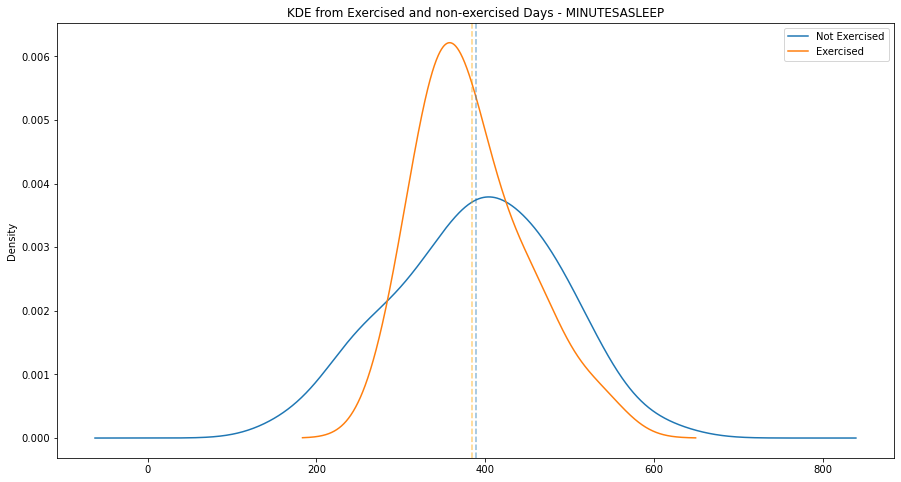

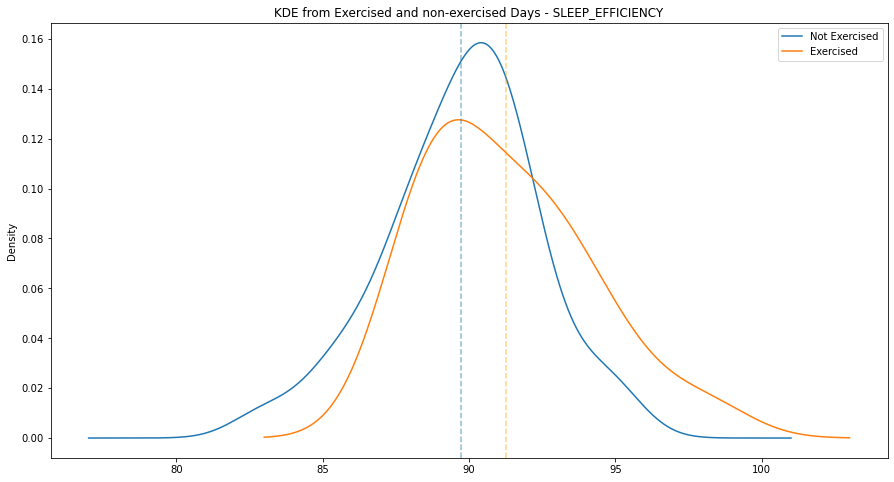

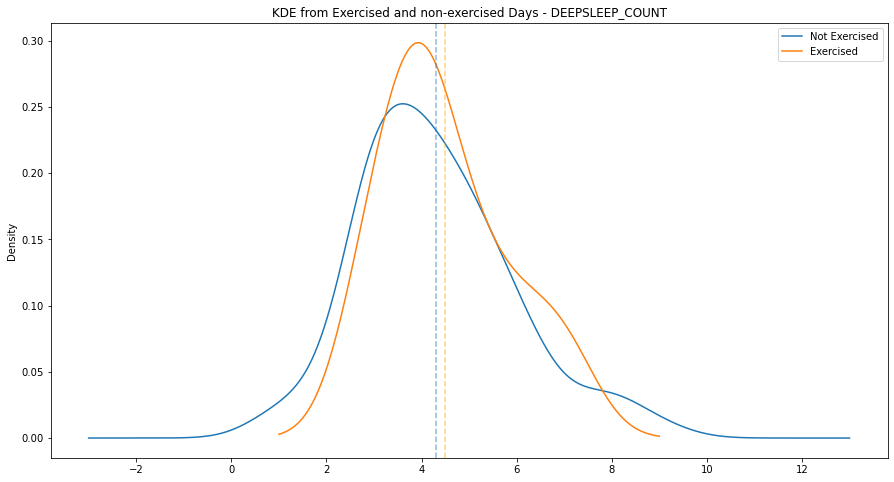

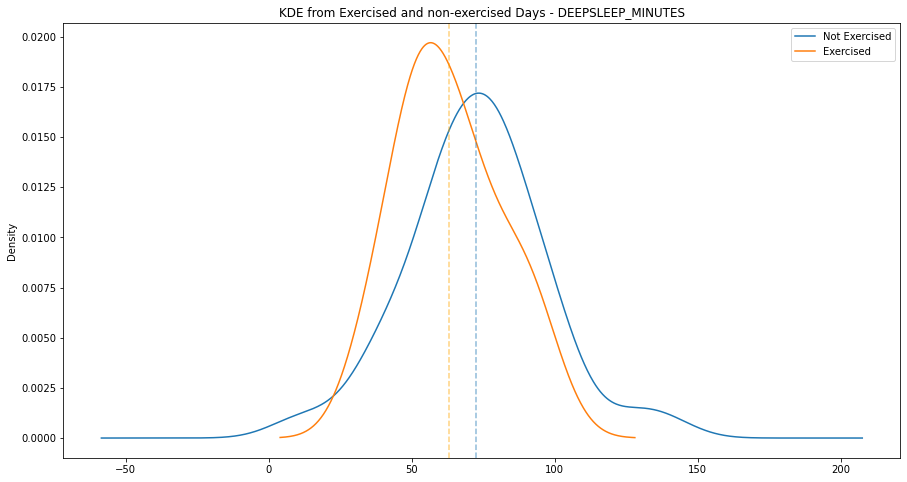

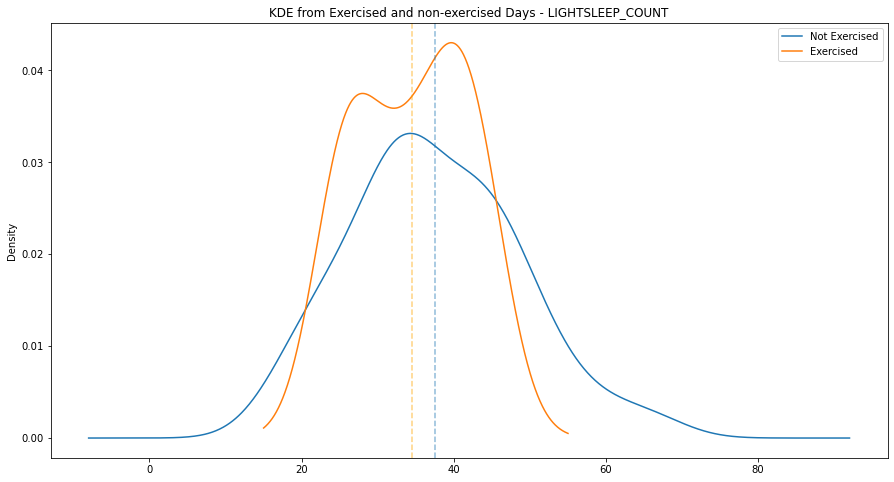

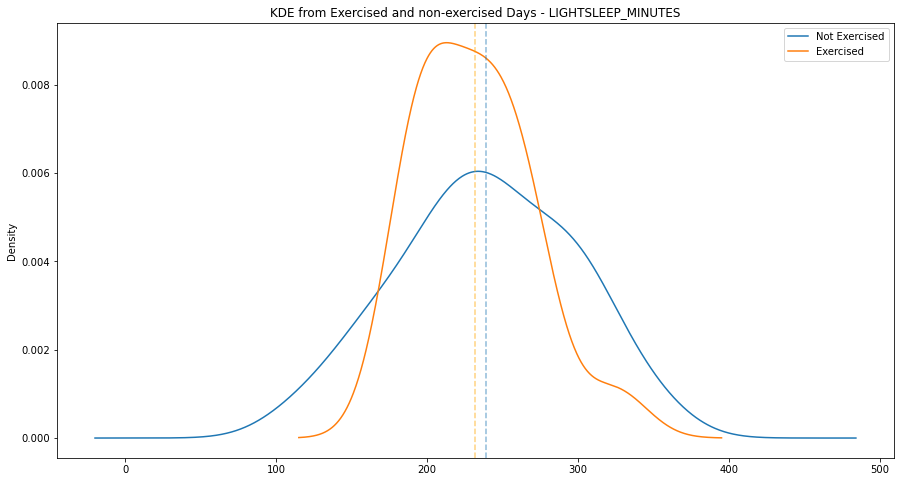

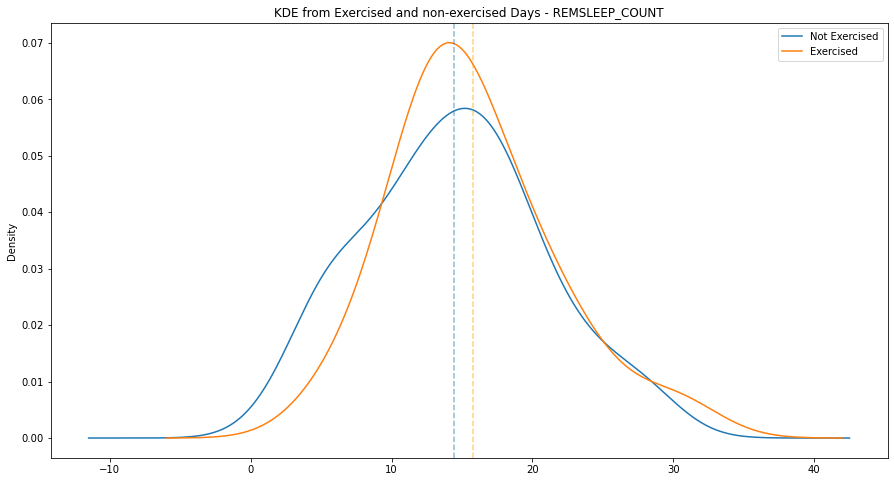

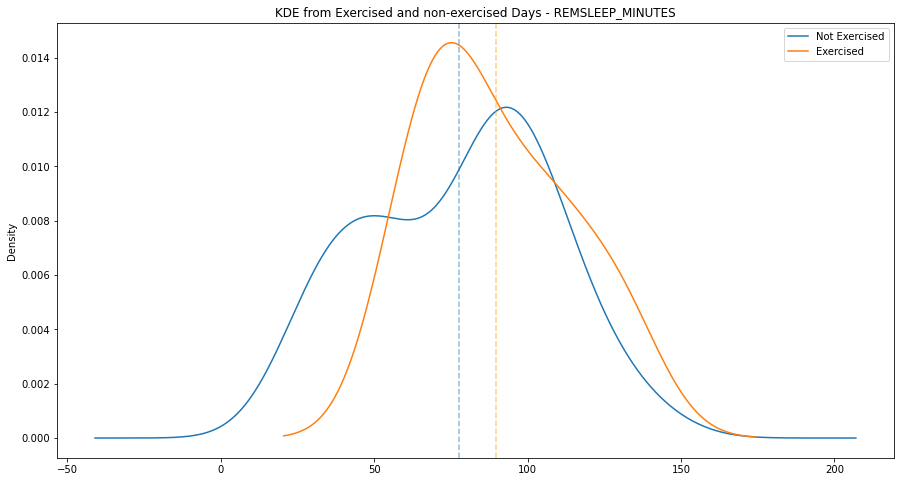

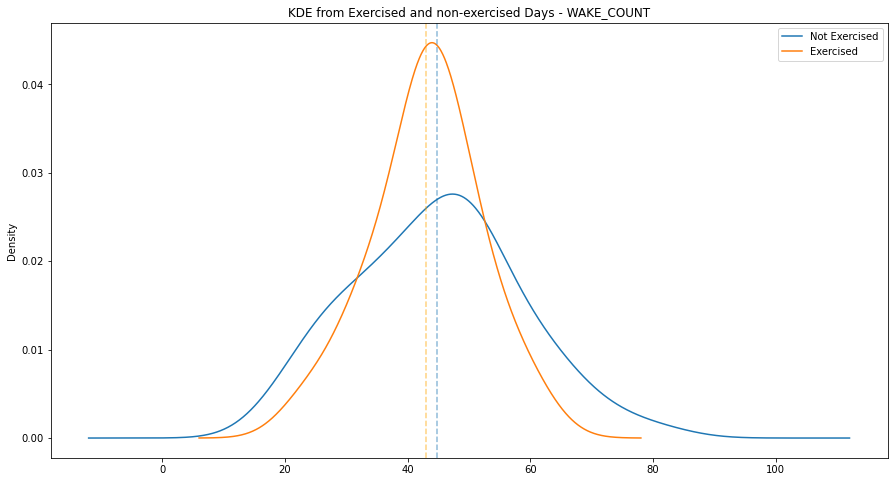

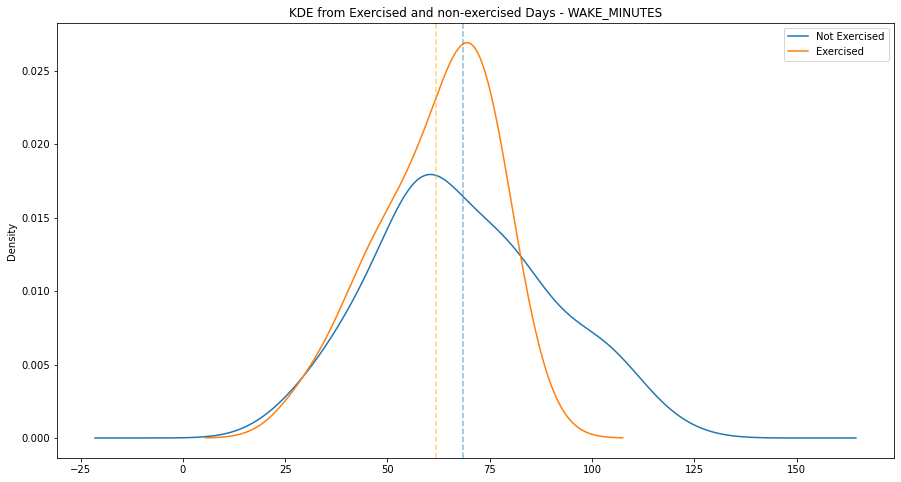

In [65]:
# Comparing Exercised VS non-exercise using above DATA:

for col_y in combi_1.columns:
    plt.figure(figsize=(15,8))
    DATA[DATA.had_exercised == False][col_y].plot(kind='kde',label='Not Exercised')
    DATA[DATA.had_exercised == True][col_y].plot(kind='kde',label='Exercised')

    plt.axvline(DATA[DATA.had_exercised == False][col_y].mean(),ls='--',alpha=0.5)
    plt.axvline(DATA[DATA.had_exercised == True][col_y].mean(),c='orange',ls='--',alpha=0.5)

    plt.legend()
    plt.title("KDE from Exercised and non-exercised Days - " + col_y.upper())
plt.show()

From the above comparison of the mean lines, there seems to be an improvement to Sleep efficiency when exercised, lesser wake during sleep. More Occurance of Deep Sleep and REM Sleep, which studies shows are indicators of good sleep.